## 프로토콜 수정사항
- peer는 homs에 join할 때, priority-ticket을 받아야 한다.
- 이 ticket은 peer-id와는 다른 개념으로 처리되어야 한다.
- 한번에 한 노드 맛 가는 경우만 고려되어 있다. 한번에 몇 개 씩 맛탱이 가는 상황도 고려해야 한다. 쓰레드로 돌려야 하나? 그럼 mutex 곳곳에 걸어야 하는디... 좀더 robust 한 방법이 필요하긴 하다.. 서버를 경유하든...뭘하든 해서..
 
- incoming이 꽉 차 있고, 새로운 요청의 ticket값이 앞서면 걔를 넣고, 전에 있던 놈중에 제일 꼬다리에 있는 놈 쪼까내기.
    - 모든 HELLO에 이렇게 할 순 없고, recovery 필드의 값이 true인 경우에만 이리 하도록 함.
    - 이렇게 했더니, HELLO의 TTL과 ITERATION수를 대폭 줄여도 안정적으로 돌아감 (TTL: 4->3, ITER: 4->1)
    
    

In [1]:
from random import *
import logging
import sys


In [2]:
%matplotlib inline
import matplotlib.pylab as plt

sys.setrecursionlimit(1500)
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.color'] = 'r'
plt.rcParams['axes.grid'] = True

In [3]:
from IPython.display import Audio, display
def sound_alert():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))


In [4]:
import networkx as nx
import matplotlib.pyplot as plt

### LogLevel

DEBUG < INFO < WARNING < ERROR < CRITICAL

In [5]:

# log기록을 남기기 위한 변수
logger = logging.getLogger("HP2P")
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_hander=logging.StreamHandler()
stream_hander.setFormatter(formatter)
logger.addHandler(stream_hander)
logger.setLevel(logging.INFO)

DEFAULT_REQUESTING_NUM_CONN = 20

MAX_PRIMARY_CONN = 10
MAX_INCOMING_CANDIDATE = 5 # 높을수록 좋음.
MAX_OUTGOING_CANDIDATE = 3

PEER_STATE_ACTIVE=1
PEER_STATE_INACTIVE=0

CONFIG_DO_SLICE_HELLO=False
CONFIG_DEFAULT_HELLO_TTL=4
CONFIG_DEFAULT_HELLO_ITERATION=1
CONFIG_DEFAULT_LEAF_POSITION_RATIO=0.7

In [6]:
class HP2P_Node:
    
    def __init__(self):
        
        self.state = PEER_STATE_ACTIVE
        self.id=-1
        self.primary = list()
        self.outgoing_candidate = list()
        self.incoming_candidate = list()    
        
        self.num_conn = 0
        self.num_primary = 0    
        self.cookie=dict()

        
        
    def add_incoming(self, node):
        
        if(self.id > node.id):
            logger.debug("%d denied to accept %d as an incoming candidate", self.id, node.id)
            return False
        
        
        if(node in self.primary or node in self.incoming_candidate or node in self.outgoing_candidate):
            logger.debug("%d is already existing with this(%d), and ignored", node.id, self.id)
            return False
            
        if(node not in self.incoming_candidate):
            logger.debug("%d adds %d into incoming_candidate list", self.id, node.id)
            self.incoming_candidate.append(node)
        else:
            logger.debug("%d is already existing incoming candidate, and ignored", node.id)
        return True

    def add_outgoing(self, node):
        if(node not in self.outgoing_candidate):
            self.outgoing_candidate.append(node)
        else:
            logger.debug("%d is already existing outgoing candidate, and ignored", node.id)
            
        return        

    def recover_outgoing_candidate(self, ttl=CONFIG_DEFAULT_HELLO_TTL, iteration=0):

        if(iteration >= CONFIG_DEFAULT_HELLO_ITERATION):
            logger.info('[recover_outgoing_candidate] max iteration. failed --> RECOVERY HELLO')
            entry_idx, entry_node=sim.get_entry_node(self.id)
            if(entry_node is None):
                logger.info('%d got no entry node. It may be normal', self.id)
                return False
            logger.info('[final iteration] %d send recovery HELLO to %d',self.id ,entry_node.id)
            entry_node.HELLO_PEER(self, entry_node, 10000, recovery=True)  
            
            if(len(self.outgoing_candidate)==0): 
                logger.critical('WORST CASE. LOGICAL ERROR. CAN NOT BE REPAIRED') 
                logger.info('Entry Nodes in order : %d %d %d %d', sim.nodelist[0].id, sim.nodelist[1].id, sim.nodelist[2].id, sim.nodelist[3].id,  )                 
                sound_alert()
                self.debug_print()
                sim.nodelist[0].debug_print()
                sim.nodelist[1].debug_print()
                sim.nodelist[2].debug_print()
                sim.nodelist[3].debug_print()
                
                return False
            else:
                return True
        
        entry_idx, entry_node=sim.get_entry_node(self.id)
        if(entry_node is None):
            logger.info('%d got no entry node. It may be normal', self.id)
            return False

        logger.info('[%d iteration] %d send HELLO to %d',iteration, self.id ,entry_node.id)
        entry_node.HELLO_PEER(self, entry_node, ttl)    
        if(len(self.outgoing_candidate)==0): 
            self.recover_outgoing_candidate(ttl=ttl*2, iteration=iteration+1)
        
    def leave(self):
        
        self.state = PEER_STATE_INACTIVE
        logger.debug("%d is leaving", self.id)
        for node in self.primary:
            
            logger.debug('[leave] %d processing begin', node.id)
            
            if(self in node.primary):
                node.primary.remove(self)
            else:
                logger.critical("%d has no primary relation with %d, but trying to remove", self.id, node.id)
                
            if(self.id < node.id):    
                if(len(node.outgoing_candidate)==0): 
                    ret=node.recover_outgoing_candidate()
                    if(ret==False):
                        logger.info("[leave] %d recover_outgoing_candidate failed ... pass", node.id)

                if(node.set_primary()==False):
                    logger.critical('%d failed to be connected to this tree, so, WHAT???', node.id)
            else:
                logger.debug('%d ignoring %d', self.id, node.id)

            logger.debug('[leave] %d processing finished', node.id)
                
            
        
        for node in self.outgoing_candidate:
            if(self in node.incoming_candidate):
                node.incoming_candidate.remove(self)
            else:
                logger.critical("no incoming_candidate ??? ")
        
        for node in self.incoming_candidate:
            if(self in node.outgoing_candidate):            
                node.outgoing_candidate.remove(self)
            else:
                logger.critical("no outgoing_candidate ??? ")
                 
        return
    
    def set_remote_primary(self, node):
        if(node in self.incoming_candidate):
            logger.debug(" --> %d is calling 'set_remote_primary' to establish primary with %d ", self.id, node.id)
            if(node not in self.primary):
                self.primary.append(node)
            else:
                logger.debug("%d is already existing remote primary, and ignored", node.id)
                
            self.incoming_candidate.remove(node)
        else:
            pass
   


    def set_primary(self):           
        if(len(self.primary) >= MAX_PRIMARY_CONN): 
            logger.debug("exceeding max primary connection. So, skip this 'set_primary' request") 
            return
      
        if(len(self.outgoing_candidate)>0):
            shuffle(self.outgoing_candidate)
            outgoing = ((w for w in self.outgoing_candidate))
            outlist = ' '.join((str(w.id) for w in outgoing))
            
            remote=self.outgoing_candidate.pop()
            logger.debug("%d is calling 'set_primary' with %d among [%s]", self.id, remote.id, outlist) 

            if(remote not in self.primary):
                logger.debug("%d is already existing primary, and ignored", remote.id) #wrong log
                self.primary.append(remote)
                remote.set_remote_primary(node=self)
            return True
        else:
            return False
        
    

    
    

    def HELLO_PEER(self, new_node=None, ingress=None, ttl=3, cookie=None, recovery=False):
        self.num_conn = len(self.primary)+len(self.outgoing_candidate)+len(self.incoming_candidate)
    
        # 이 peer의 상태가 죽어 있을 경우에는 처리가 되어서는 아니 되므로!!
        # 하나의 피어가 죽을때 걔랑 연결되어 있는 노드들의 동작을 정의하고 있는데, recovery HELLO를 하면 상위부터
        # 다시 전파하는데 그때에는 얘가 죽은게 알려져 있지 않아서 밑으로 내려보냄. 
        # 그래서, 아래와 같이 상태 값을 넣어서 더 이상 전파가 되지 않도록 함... ==> 로직의 잠재적 문제가 있을지도..
        if(self.state == PEER_STATE_INACTIVE): 
            logger.critical('%d received HELLO but this is INACTIVE, no work. just return.', self.id)
            return
    
        # HELLO가 루프를 그릴 경우, 끊어버렷!
        if(self.id == new_node.id):
            logger.critical('LOOP!!!!! DAMN IT!!!! CUT %d OUT from Primary List in node %d', ingress.id, self.id)
            self.primary.remove(ingress)
            ingress.primary.remove(self)
            return
            
        if(cookie is not None and ingress != self):
            logger.info('%d sent HELLO to %d with cookie=%s of node %d', ingress.id, self.id, cookie, new_node.id)
            if(new_node.id in self.cookie):
                logger.info('%s vs %s', cookie, self.cookie.get(new_node.id))
                if(cookie == self.cookie[new_node.id]):
                    logger.info('return PROTO_COOKIE_ERROR')
                    return PROTO_COOKIE_ERROR

        if(ttl <= 1):
            logger.debug('HELLO for node %d has expired TTL in node %d', new_node.id, self.id)
            return
        else:
            ttl -= 1
        
        if(len(self.incoming_candidate) < MAX_INCOMING_CANDIDATE):
            if(self.add_incoming(new_node)==True):
                new_node.add_outgoing(self)                
                
        elif(recovery):
            logger.info('%d can not accomodate more incoming_candidate', self.id)
            last_node = self.incoming_candidate.pop()
            last_node.outgoing_candidate.remove(self)
            if(self.add_incoming(new_node)==True):
                logger.info('%d kick one of incoming_candidate %d, and added %d', self.id, last_node.id, new_node.id)
                new_node.add_outgoing(self) 
            

        for path in self.primary:
            if(path.id != ingress.id):   
                # step_num을 제대로 나누도록 수정 필요. --> TTL로 변경함.
                # e.g, 5 ---> 2, 3
                if(path.state != PEER_STATE_INACTIVE):   
                    if(ttl > 0):
                        logger.debug('Forward HELLO(%d) from %d to %d, ttl = %d', new_node.id, self.id, path.id, ttl)
                        path.HELLO_PEER(new_node=new_node, ingress=self, ttl=ttl)
                    else:
                        logger.debug('ttl(%d) expired in node %d, message ignored', ttl, self.id)
                        

                else:
                    prime = ((w for w in self.primary))
                    primelist = ' '.join((str(w.id) for w in prime))
                    logger.debug('My primary %d [among %s] is DEAD', path.id, primelist)
                    
            
        return

    def debug_print(self):
        
        logger.info('--== %d status ==--', self.id)
        
        lst = ((w for w in self.primary))
        lststr = ' '.join((str(w.id) for w in lst))
        logger.info('Primary : [%s]', lststr)
        
        lst = ((w for w in self.outgoing_candidate))
        lststr = ' '.join((str(w.id) for w in lst))
        logger.info('Outgoing : [%s]', lststr)
        
        lst = ((w for w in self.incoming_candidate))
        lststr = ' '.join((str(w.id) for w in lst))
        logger.info('Incoming : [%s]', lststr)
        
    
    def print(self):
        print("\n(%d)----------------------------"%self.id)                
        print("Primary : ", end='')
        for index, value in enumerate(self.primary):
            print(value.id, end=' ')
        print("\nOutgoing Candidate : ", end='')
        for index, value in enumerate(self.outgoing_candidate):
            print(value.id, end=' ')   
        print("\nIncoming Candidate : ", end='')
        for index, value in enumerate(self.incoming_candidate):
            print(value.id, end=' ')  
        print("\n-------------------------------")                


In [7]:
class HP2P_Sim:
    
    nodelist=list()
    ticket_count=0
    def __init__(self):
        pass
    
    def get_random_leaf_node(self):
        if(len(self.nodelist)==0): return 0, None
        entry_idx = int((len(self.nodelist)-1) * CONFIG_DEFAULT_LEAF_POSITION_RATIO)
        return entry_idx, self.nodelist[entry_idx]
    
    
    def get_random_entry_node(self, id):
        if(len(self.nodelist)==0): return 0, None
        
        entry_idx = randint(0, len(self.nodelist)-1)
        while(self.nodelist[entry_idx].id == id):
            entry_idx = randint(0, len(self.nodelist)-1)
        return entry_idx, self.nodelist[entry_idx]

    
    # HELLO를 보낼 노드를 찾아냄
    # Peer <---(get peerlist)---> HOMS
    def get_entry_node(self, ticket):
        if(len(self.nodelist)==0): return 0, None
        

        # 지금은 그냥 무조건 남아있는 녀석들 중 가장 ticket값이 제일 낮은 녀석만 던지게 했음.
        # 이렇게 하면 안정적으로 잘 돌아감.
        if(self.nodelist[0].id == ticket): return -1, None
        return 0, self.nodelist[0]
    

    
    def add_node(self):
        node=HP2P_Node()
        
        
        entry_idx, entry_node=self.get_random_leaf_node()
        self.nodelist.append(node)
        
        node.id = self.ticket_count
        self.ticket_count+=1
        
        if(entry_node is not None):
            if(entry_node.id == node.id):
                entry_node=self.nodelist[0]
        else:
            return 

        entry_node.HELLO_PEER(new_node=node, ingress=self.nodelist[entry_idx], ttl=CONFIG_DEFAULT_HELLO_TTL)                
        ret=node.set_primary()
        
        
        while(ret==False):
            entry_idx, entry_node=self.get_random_entry_node(node.id)
            entry_node.HELLO_PEER(new_node=node, ingress=self.nodelist[entry_idx], ttl=CONFIG_DEFAULT_HELLO_TTL)                
            ret=node.set_primary()
            


    def add_random_node(self, num):
        
        for i in range(num):
            self.add_node()
        
        
    def del_node(self, id):
        i=0
        for i in range(len(self.nodelist)):
            if(self.nodelist[i].id == id):
                node = self.nodelist[i]
                del(self.nodelist[i])
                
                node.leave()
                break
               
            
    def del_random_node(self, num):
        
        for i in range(num):
            idx = randint(0, len(self.nodelist)-1)
            
            primary = ((w for w in sim.nodelist[idx].primary))
            message = ' '.join((str(w.id) for w in primary))
            logger.info('node %d is removed - primray %s', sim.nodelist[idx].id, message)            
            
            self.del_node(self.nodelist[idx].id)
        

    def print_node(self, node_id):
        for node in self.nodelist:
            if(node.id == node_id):
                node.print()
        
    def draw_graph(self):
        primary_edges = list()
        for i in range(len(self.nodelist)):
            for node in self.nodelist[i].primary:
                primary_edges.append((self.nodelist[i].id, node.id))

        candidate_edges = list()
        for i in range(len(self.nodelist)):
            for node in self.nodelist[i].outgoing_candidate:
                candidate_edges.append((self.nodelist[i].id, node.id))
                
        if(len(primary_edges)==0):
            primary_edges.append((0,0))
            
            
        self.draw_graph_with_edges(primary_edges, candidate_edges)
                
    def draw_graph_with_edges(self, primary_edges, candidate_edges):
        G = nx.DiGraph()
        
        if(len(primary_edges)>0):
            G.add_edges_from(primary_edges)
            pos = nx.kamada_kawai_layout(G)
        else:
            pos = nx.spring_layout(G)
            
        nx.draw_networkx_nodes(G, pos, node_size = 500)
        nx.draw_networkx_labels(G, pos)

        nx.draw_networkx_edges(G, pos, edgelist=primary_edges, arrows=False, width=2)
        if(len(candidate_edges)!=0):
            nx.draw_networkx_edges(G, pos, edgelist=candidate_edges, connectionstyle='arc3, rad=0.3', edge_color='r', arrowsize=20, style='dotted', arrows=True)
        else:
            logger.debug('No Edges,.. it is okay')
                
        try:
            nx.find_cycle(G)
        except:
            logger.critical('LOOP HAS DETECTED!!!!!')
                
                
#         node.print()

In [8]:
sim = HP2P_Sim()
plt.rcParams["figure.figsize"] = (15,15)


C:\Users\User\.conda\envs\hp2p\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\User\.conda\envs\hp2p\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


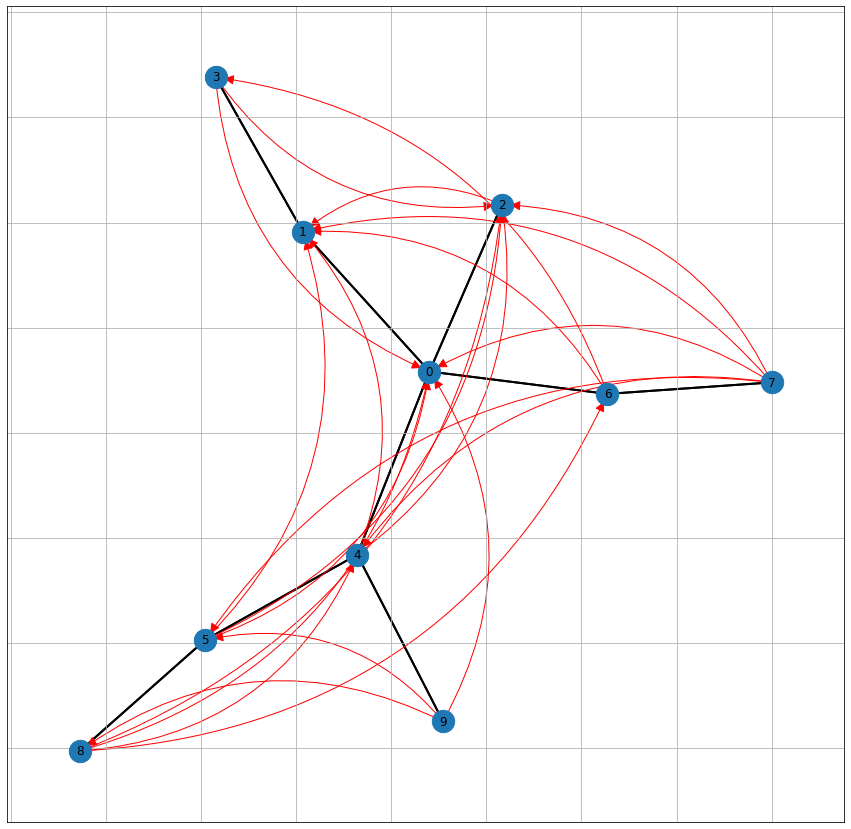

In [9]:
sim.add_random_node(10)
sim.draw_graph()

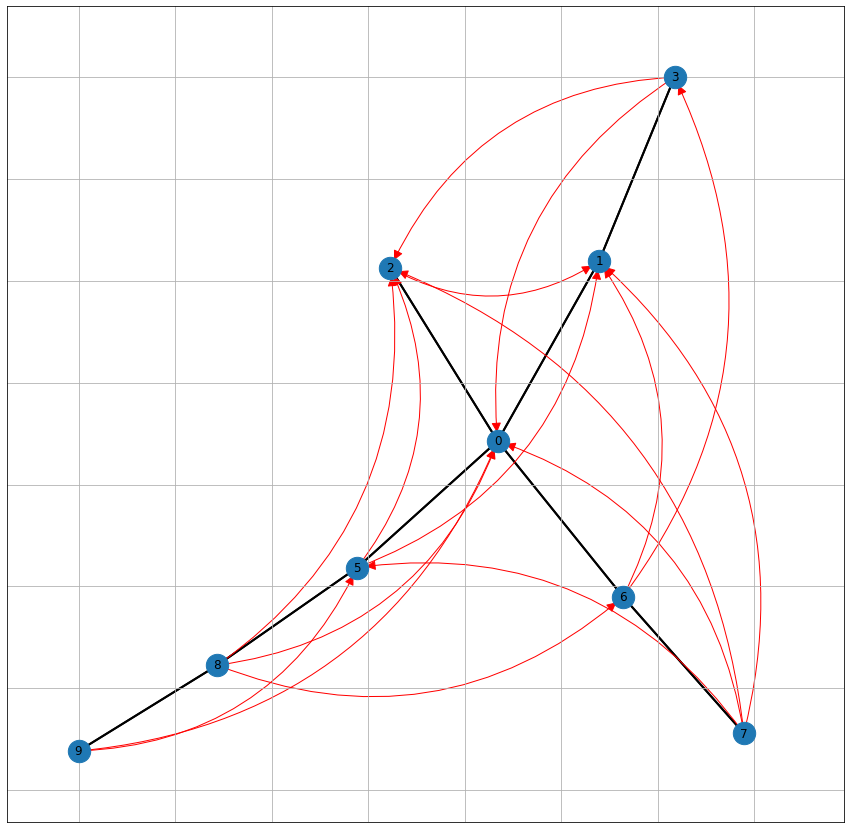

In [10]:
sim.del_node(4)
sim.draw_graph()

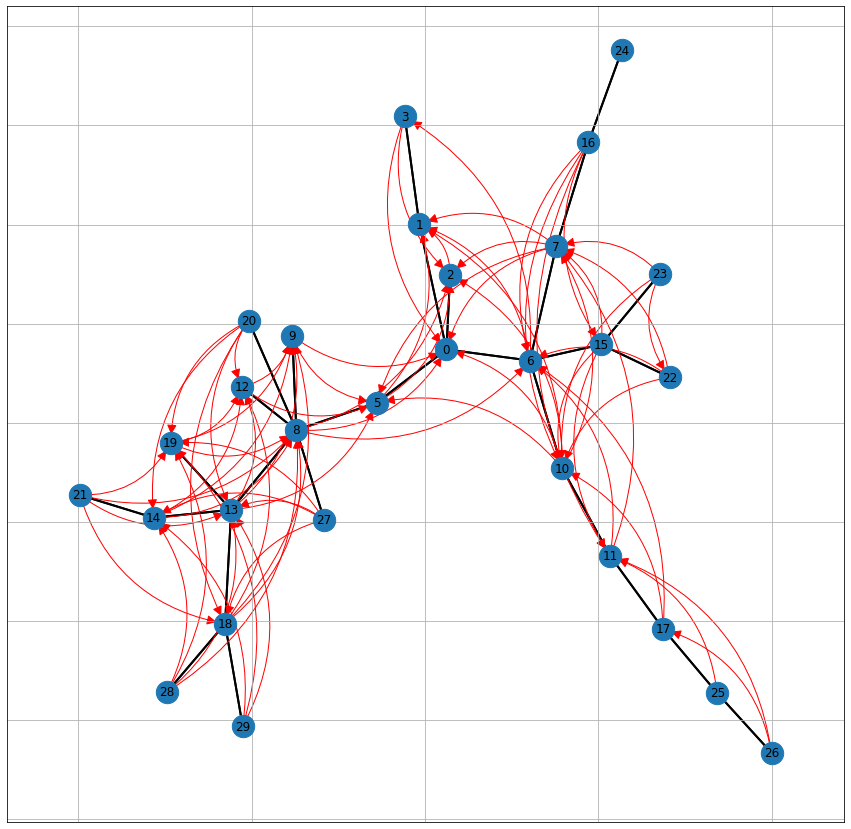

In [11]:
sim.add_random_node(20) 
sim.draw_graph()

2019-08-23 13:22:10,329 - HP2P - INFO - node 26 is removed - primray 25


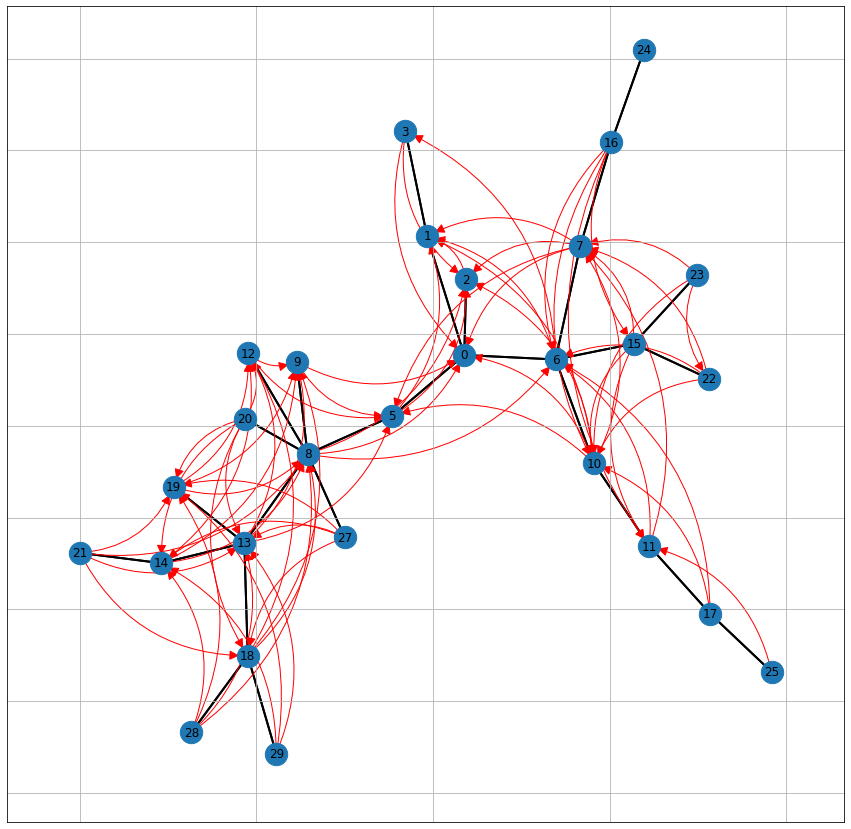

In [12]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:10,974 - HP2P - INFO - node 15 is removed - primray 6 22 23


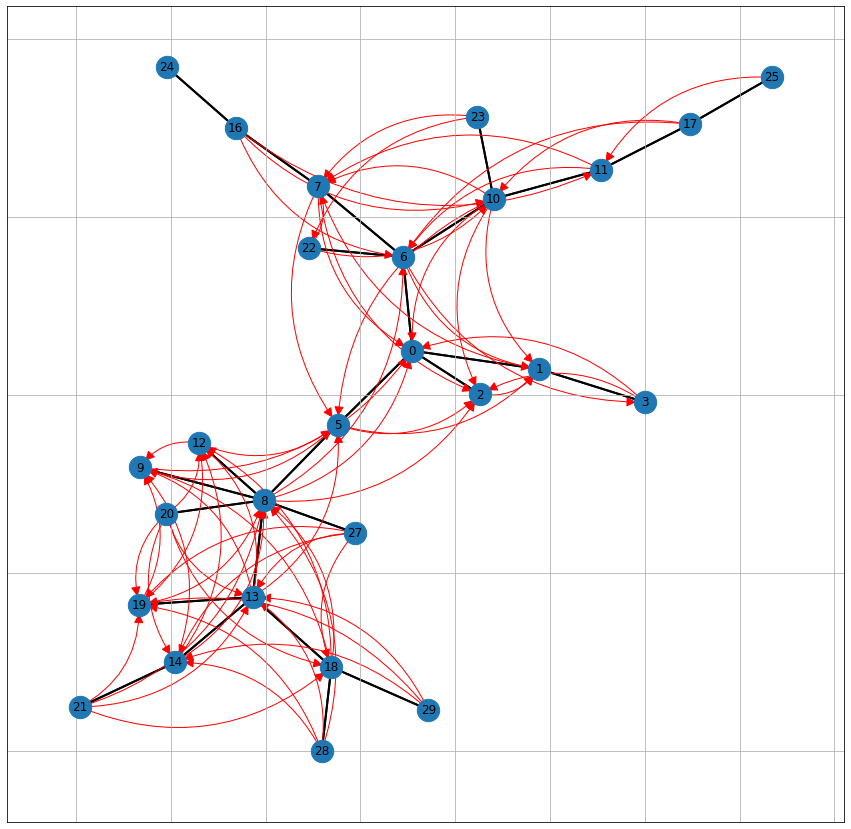

In [13]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:11,580 - HP2P - INFO - node 27 is removed - primray 8


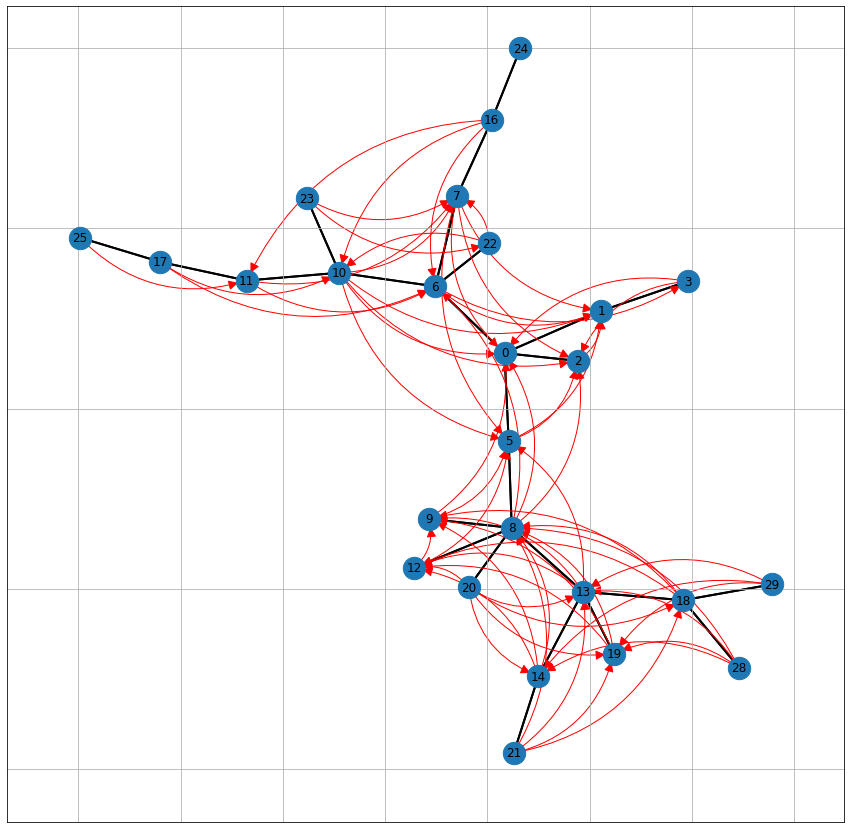

In [14]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:12,157 - HP2P - INFO - node 25 is removed - primray 17


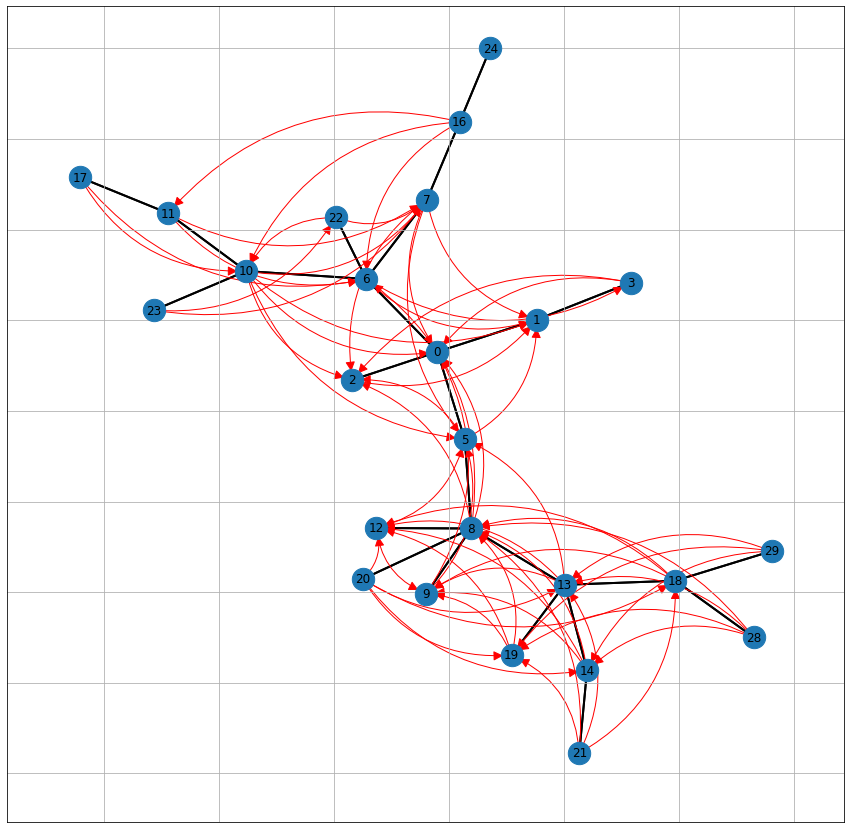

In [15]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:12,724 - HP2P - INFO - node 14 is removed - primray 13 21


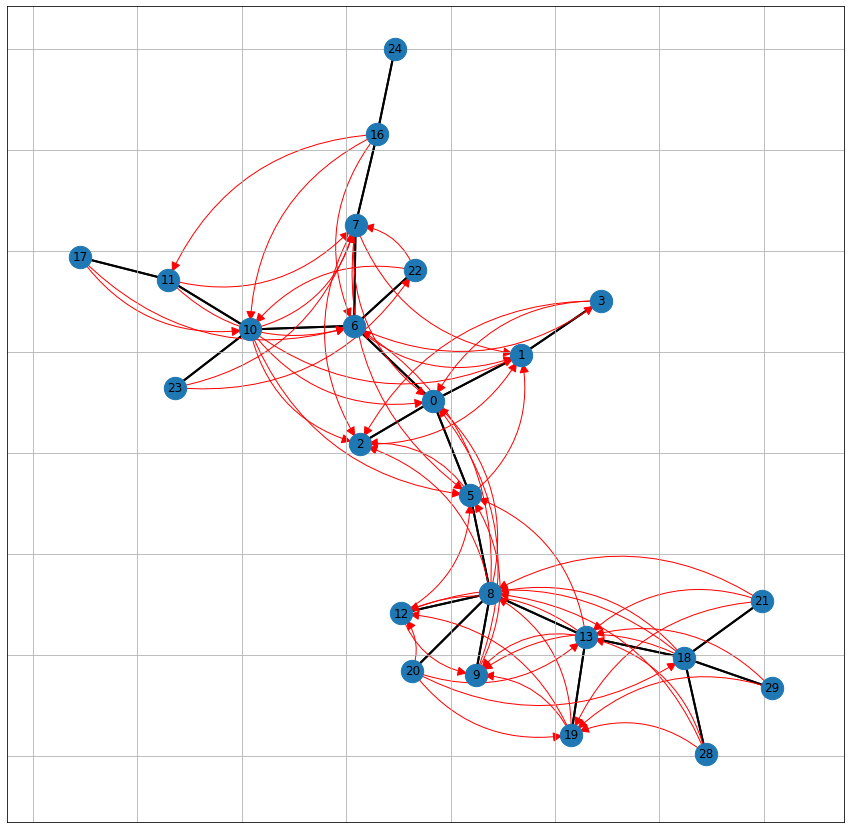

In [16]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:13,257 - HP2P - INFO - node 29 is removed - primray 18


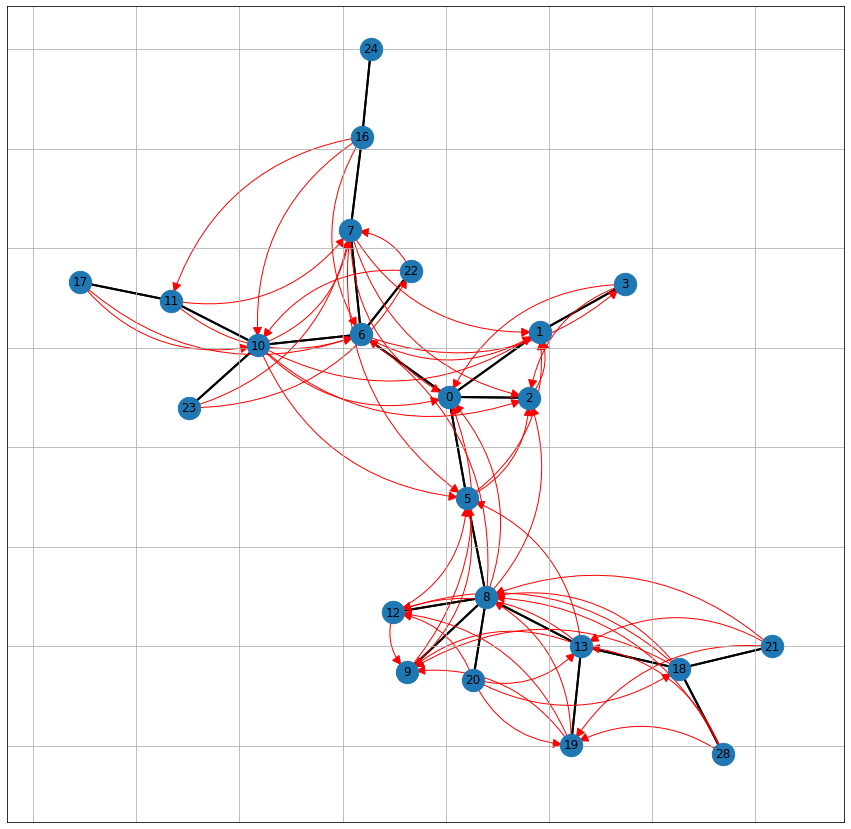

In [17]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:13,818 - HP2P - INFO - node 18 is removed - primray 13 28 21


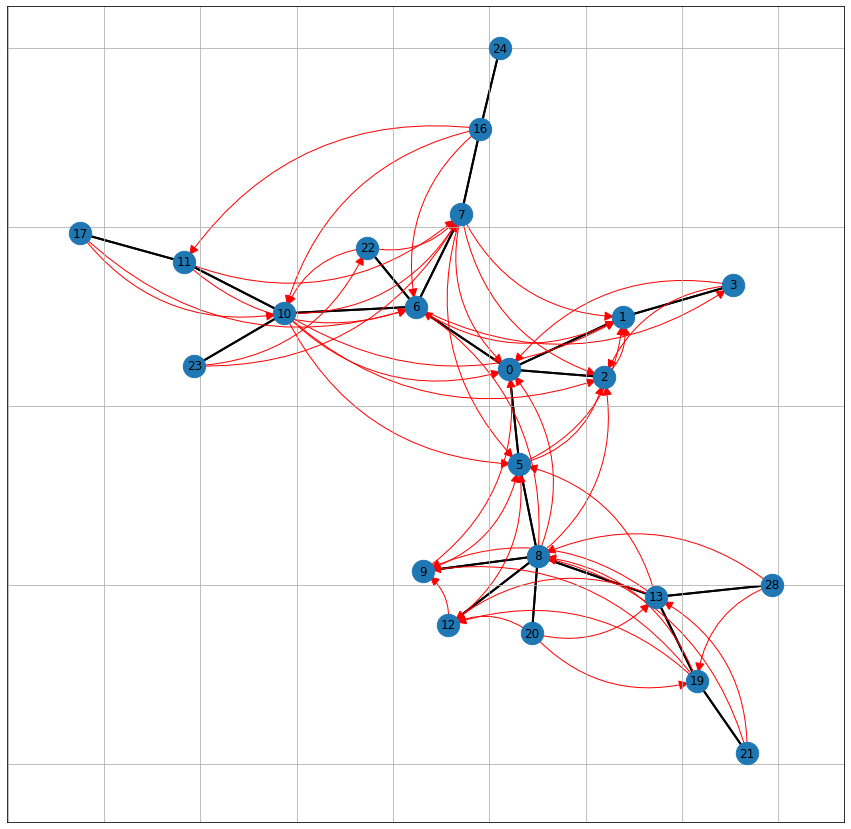

In [18]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:14,328 - HP2P - INFO - node 3 is removed - primray 1


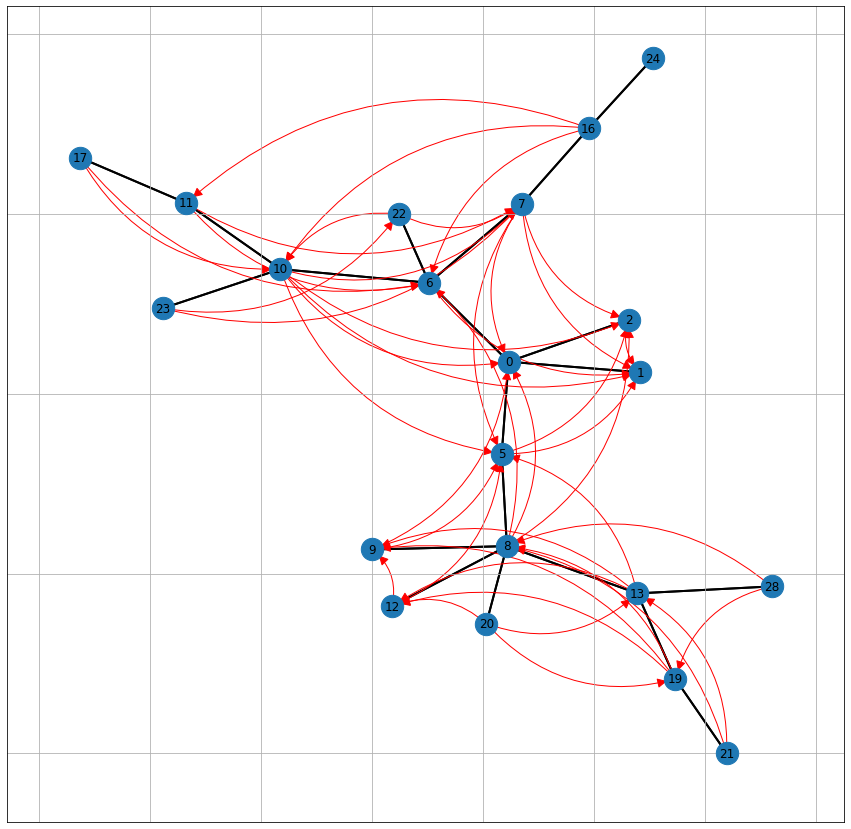

In [19]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:14,834 - HP2P - INFO - node 19 is removed - primray 13 21


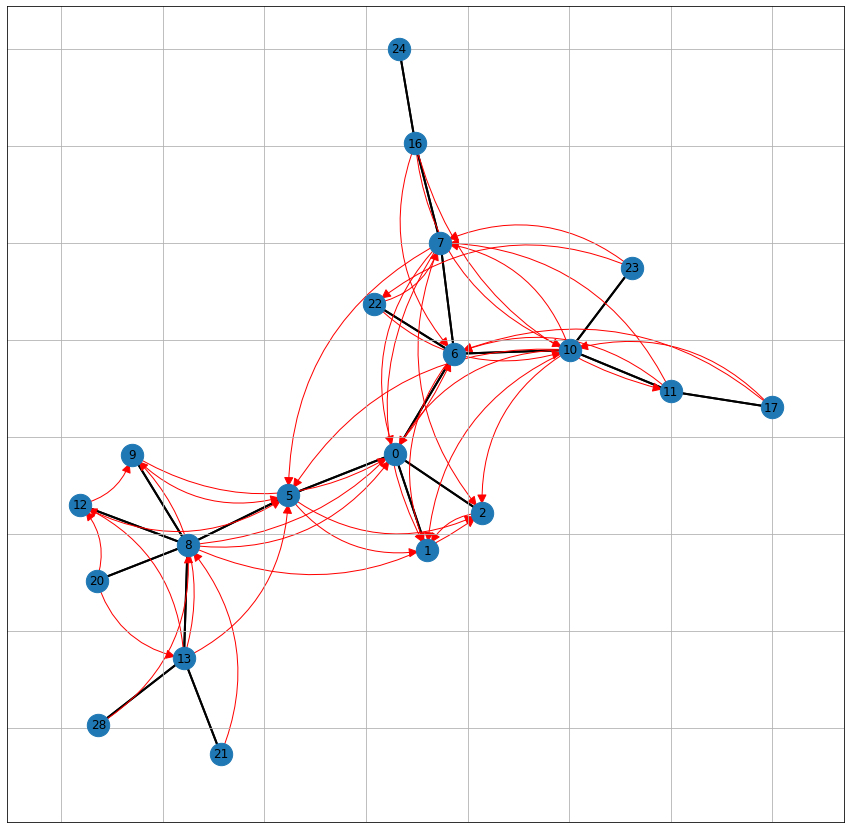

In [20]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:15,293 - HP2P - INFO - node 9 is removed - primray 8


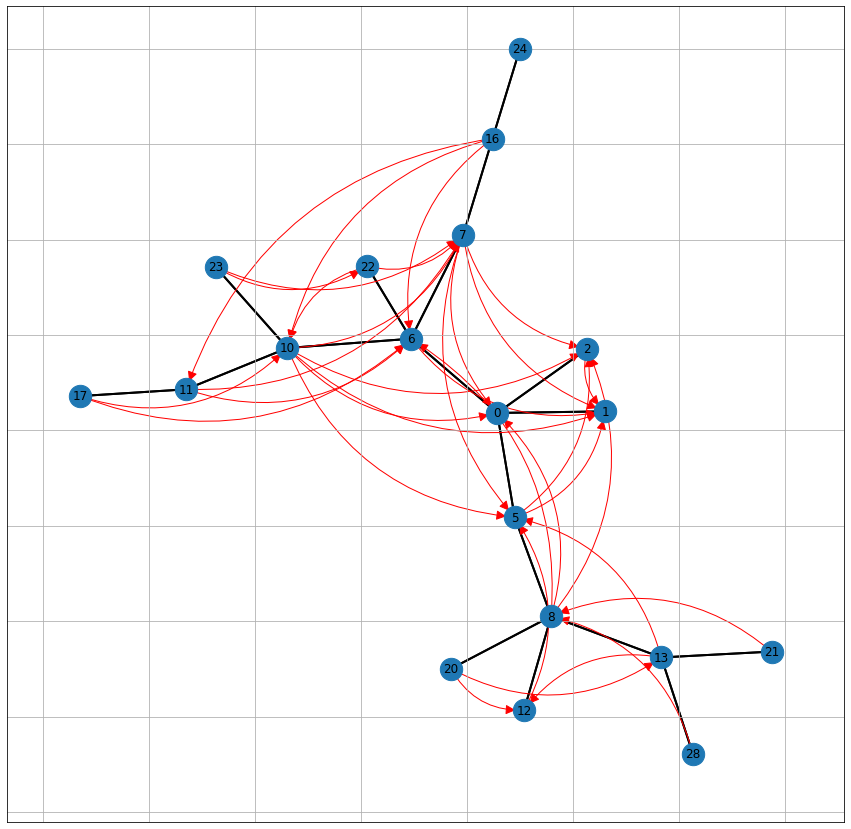

In [21]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:15,758 - HP2P - INFO - node 11 is removed - primray 10 17


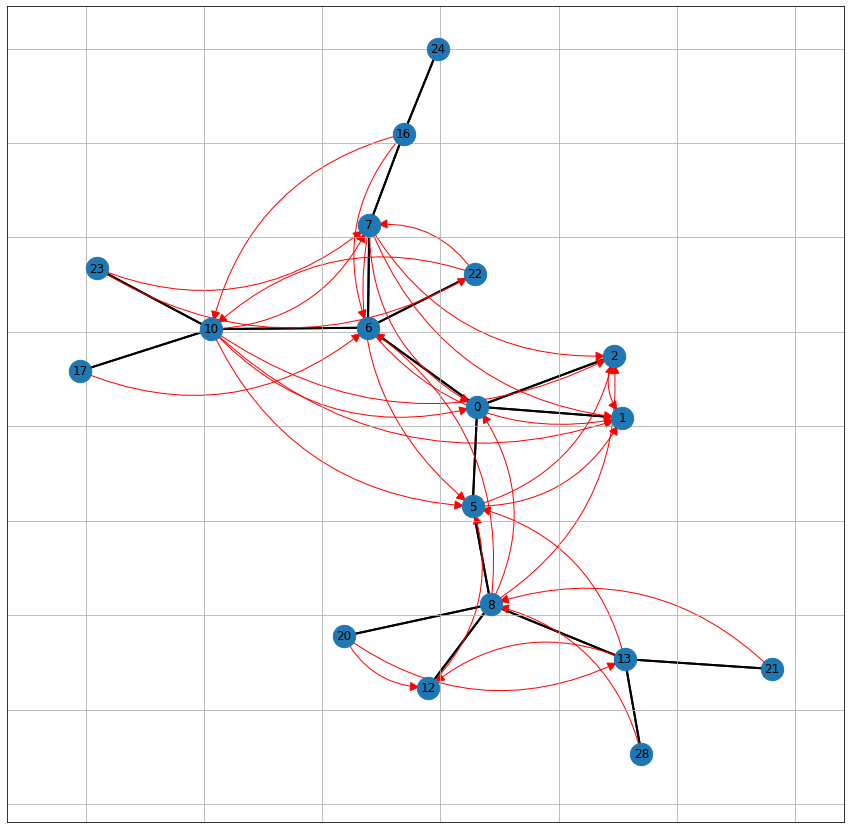

In [22]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:16,219 - HP2P - INFO - node 10 is removed - primray 6 23 17


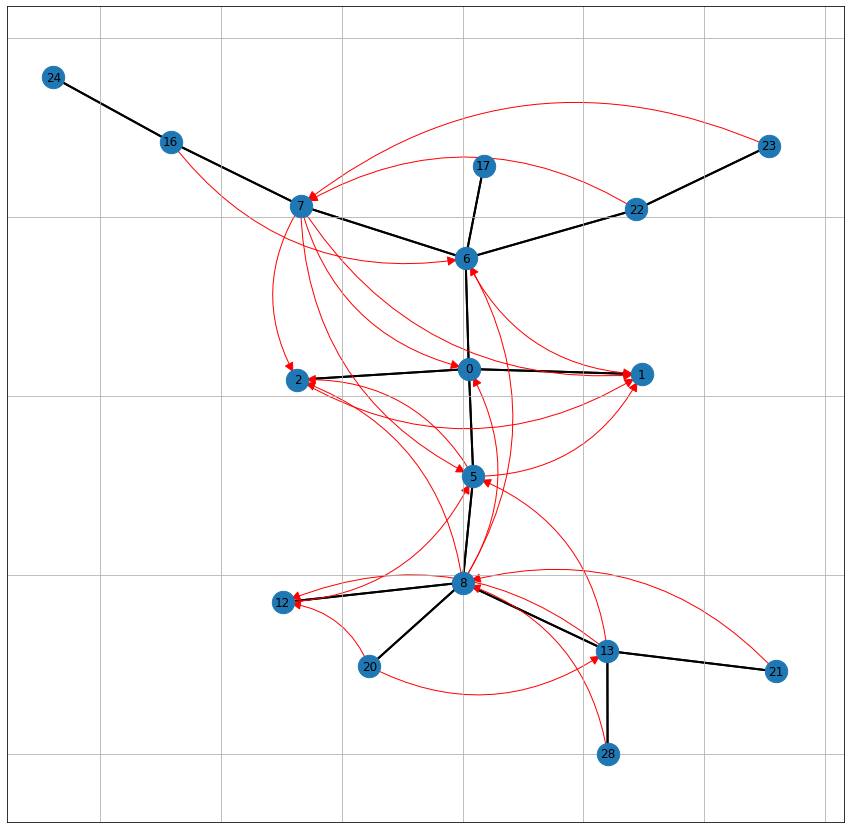

In [23]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:16,635 - HP2P - INFO - node 22 is removed - primray 6 23


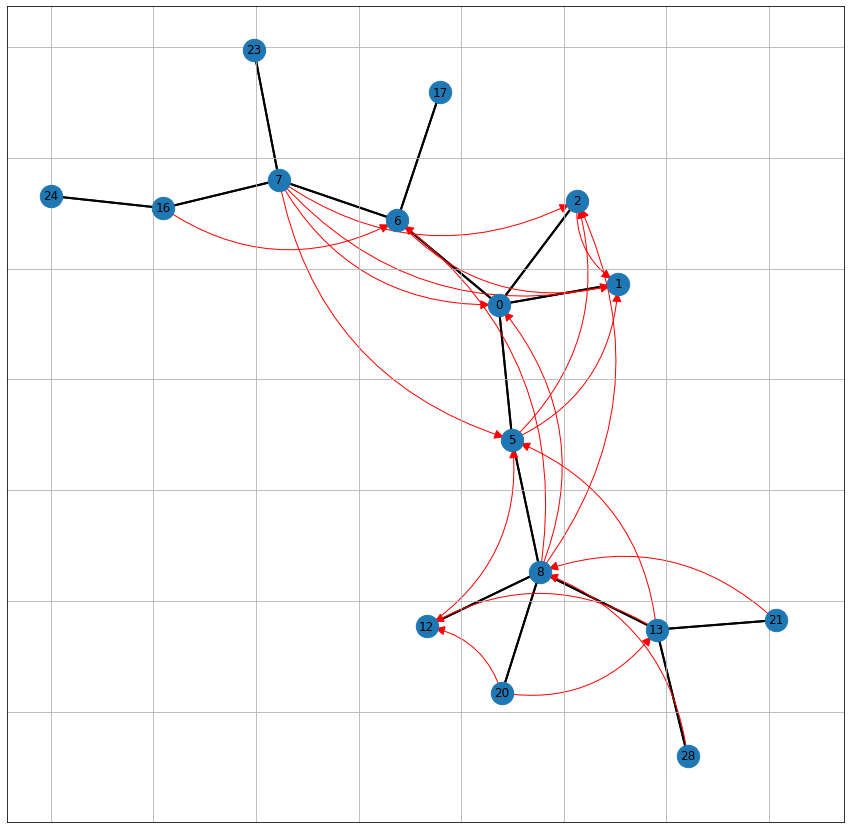

In [24]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:17,005 - HP2P - INFO - node 8 is removed - primray 5 12 13 20


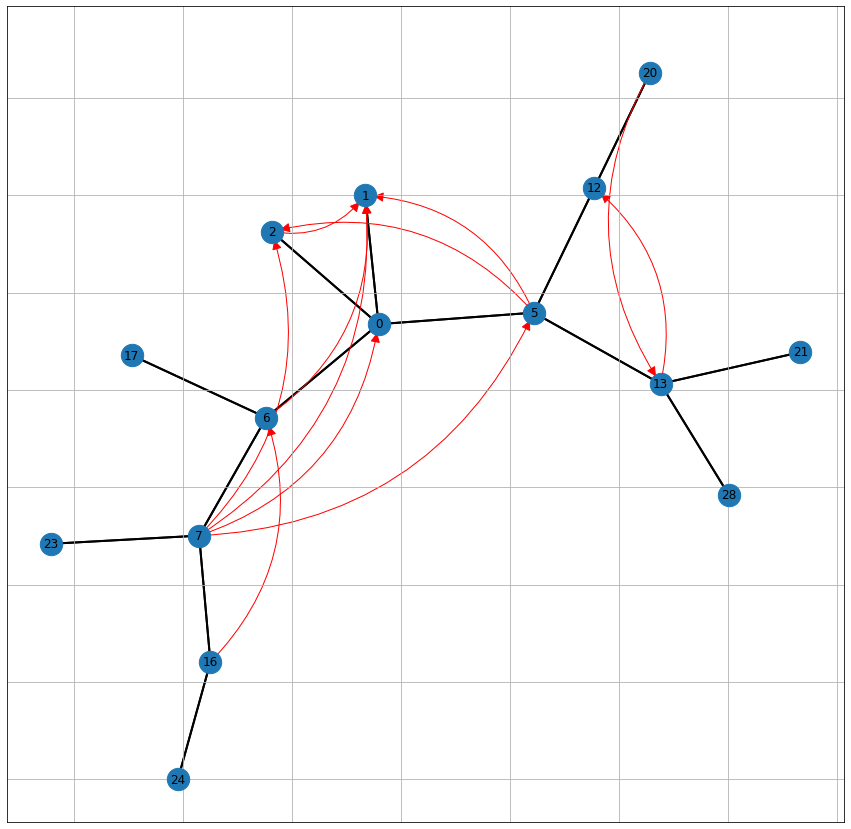

In [25]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:17,339 - HP2P - INFO - node 2 is removed - primray 0


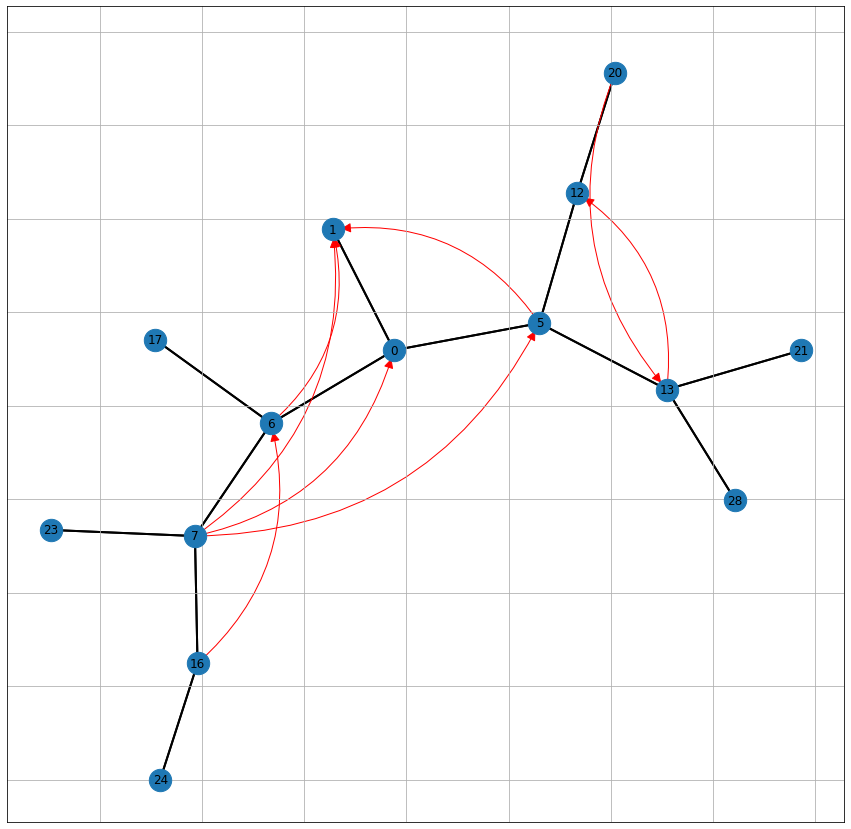

In [26]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:17,686 - HP2P - INFO - node 13 is removed - primray 28 21 5
2019-08-23 13:22:17,687 - HP2P - INFO - [0 iteration] 28 send HELLO to 0
2019-08-23 13:22:17,687 - HP2P - INFO - [0 iteration] 21 send HELLO to 0


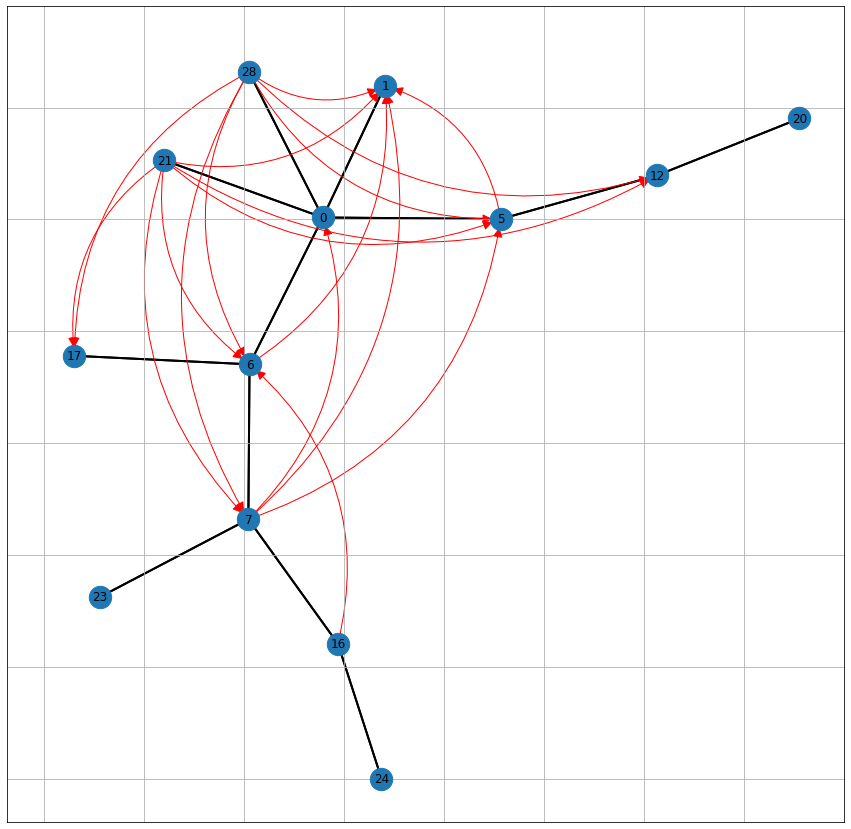

In [27]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:18,077 - HP2P - INFO - node 12 is removed - primray 5 20
2019-08-23 13:22:18,078 - HP2P - INFO - [0 iteration] 20 send HELLO to 0


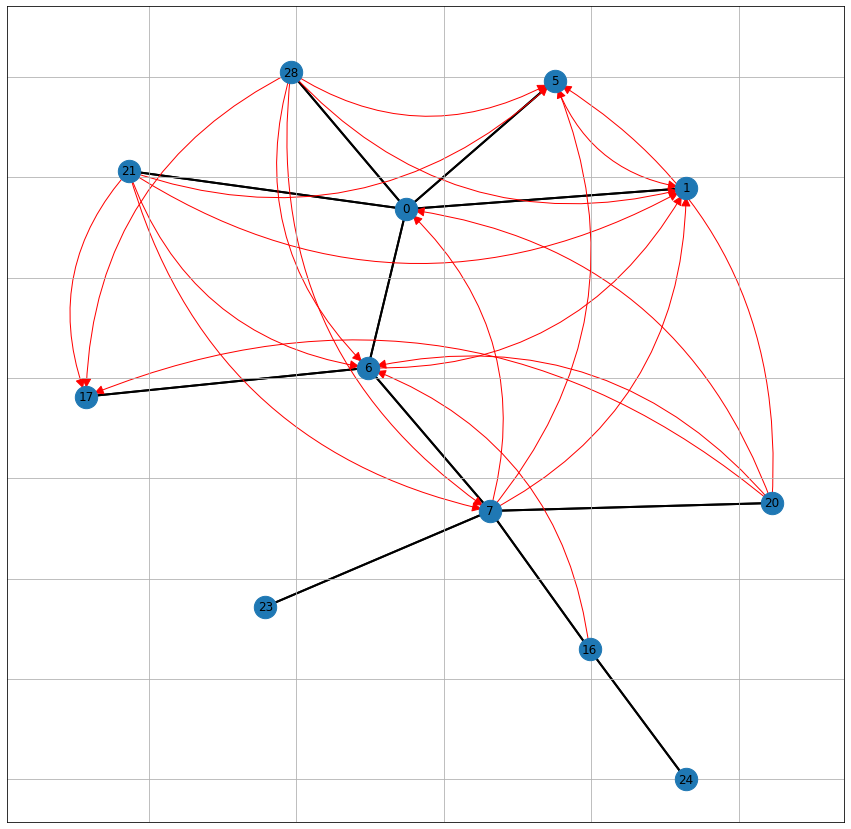

In [28]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:18,447 - HP2P - INFO - node 7 is removed - primray 6 16 23 20
2019-08-23 13:22:18,448 - HP2P - INFO - [0 iteration] 23 send HELLO to 0


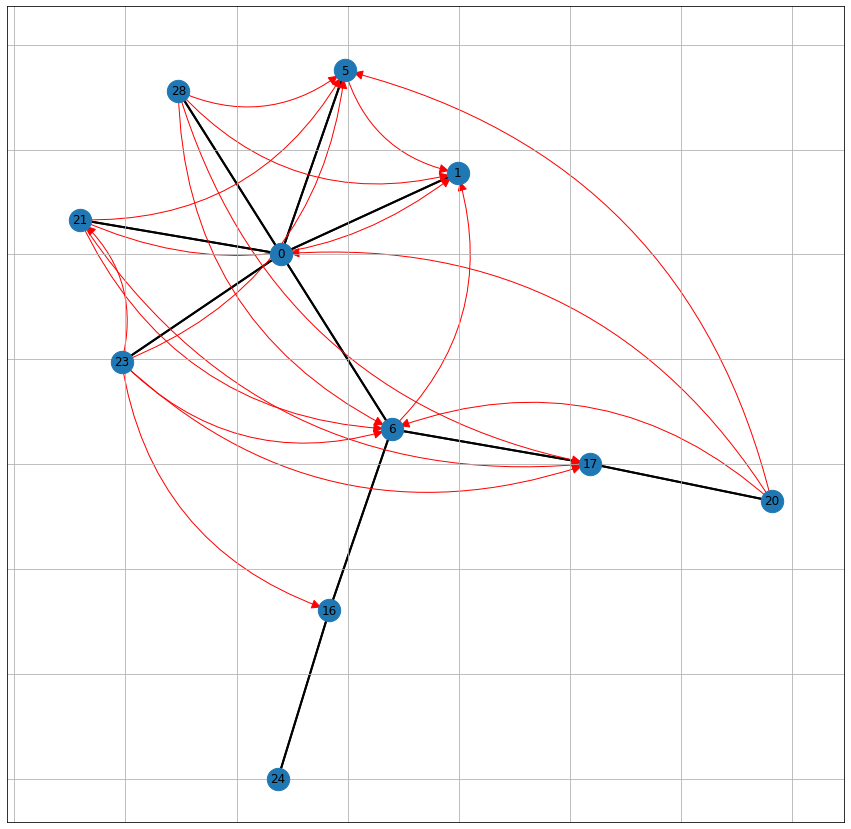

In [29]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:18,819 - HP2P - INFO - node 16 is removed - primray 24 6
2019-08-23 13:22:18,819 - HP2P - INFO - [0 iteration] 24 send HELLO to 0


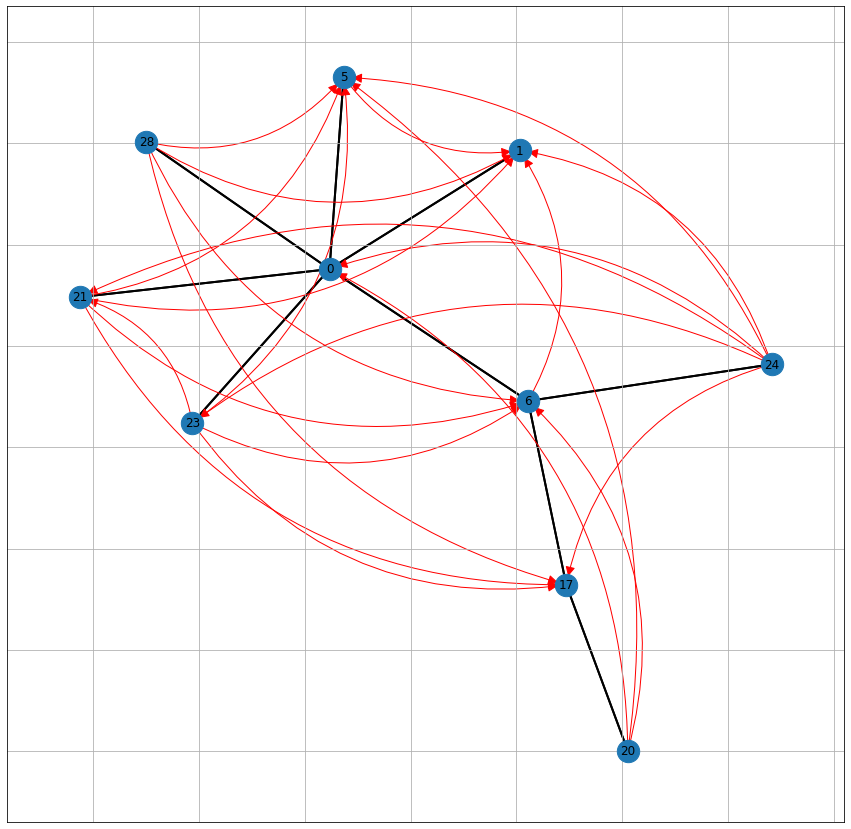

In [30]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:19,207 - HP2P - INFO - node 28 is removed - primray 0


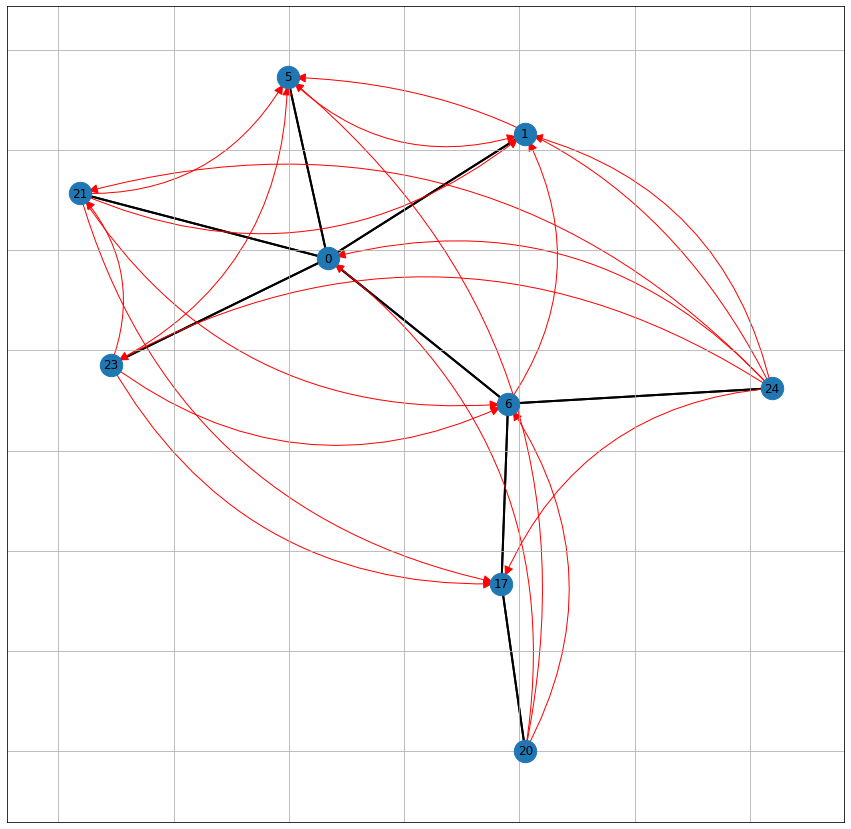

In [31]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:19,590 - HP2P - INFO - node 5 is removed - primray 0


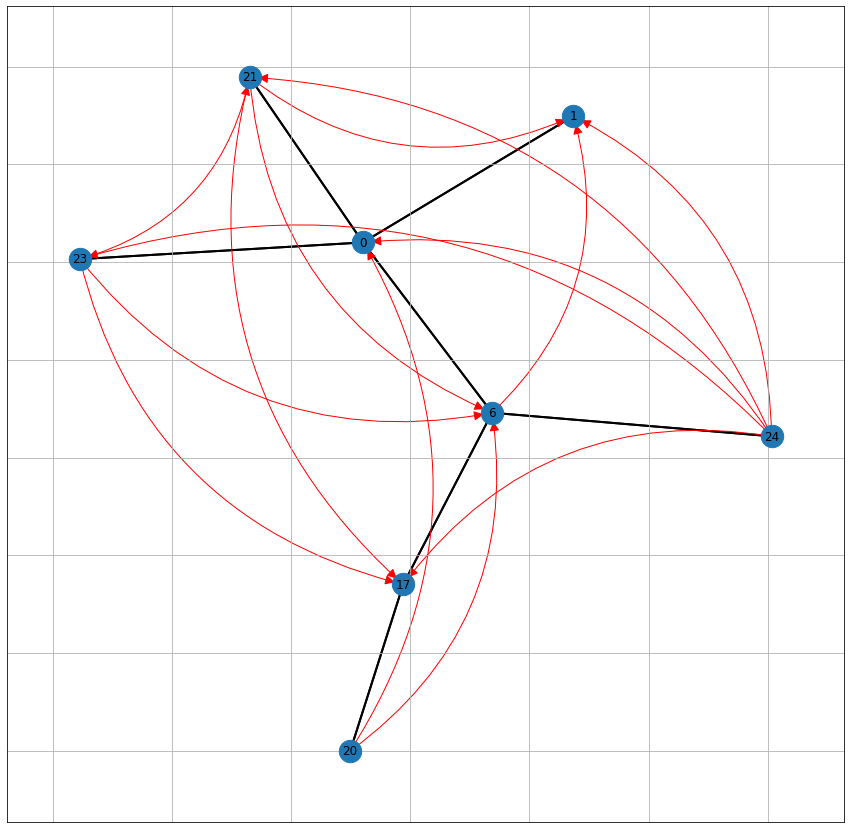

In [32]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:19,936 - HP2P - INFO - node 20 is removed - primray 17


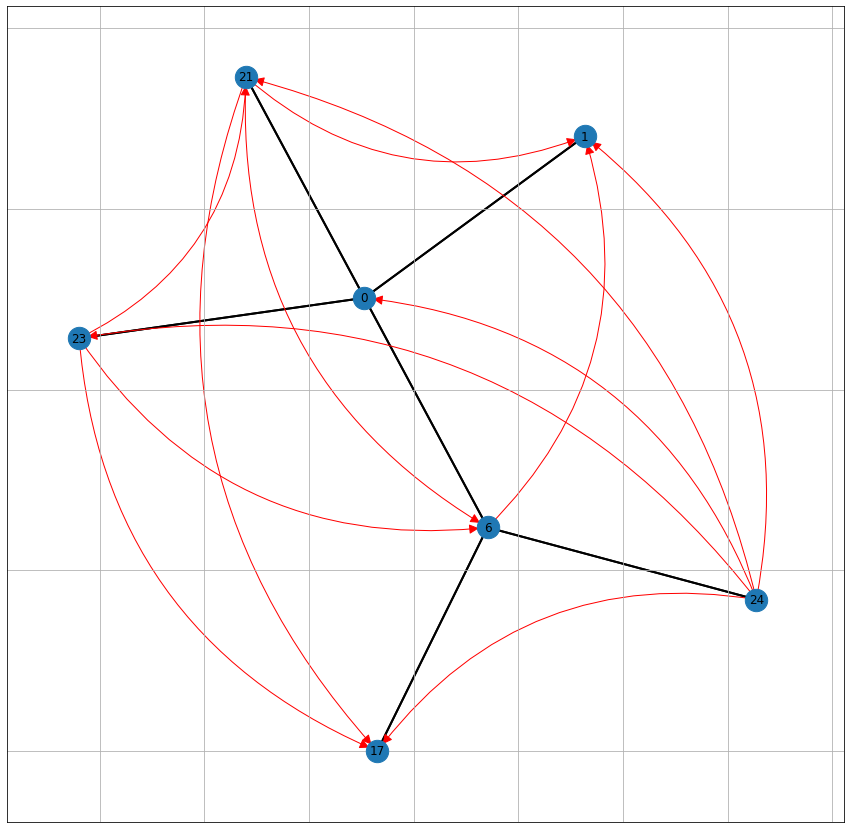

In [33]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:20,268 - HP2P - INFO - node 0 is removed - primray 1 6 21 23
2019-08-23 13:22:20,268 - HP2P - INFO - 1 got no entry node. It may be normal
2019-08-23 13:22:20,269 - HP2P - INFO - [leave] 1 recover_outgoing_candidate failed ... pass
2019-08-23 13:22:20,269 - HP2P - CRITICAL - 1 failed to be connected to this tree, so, WHAT???


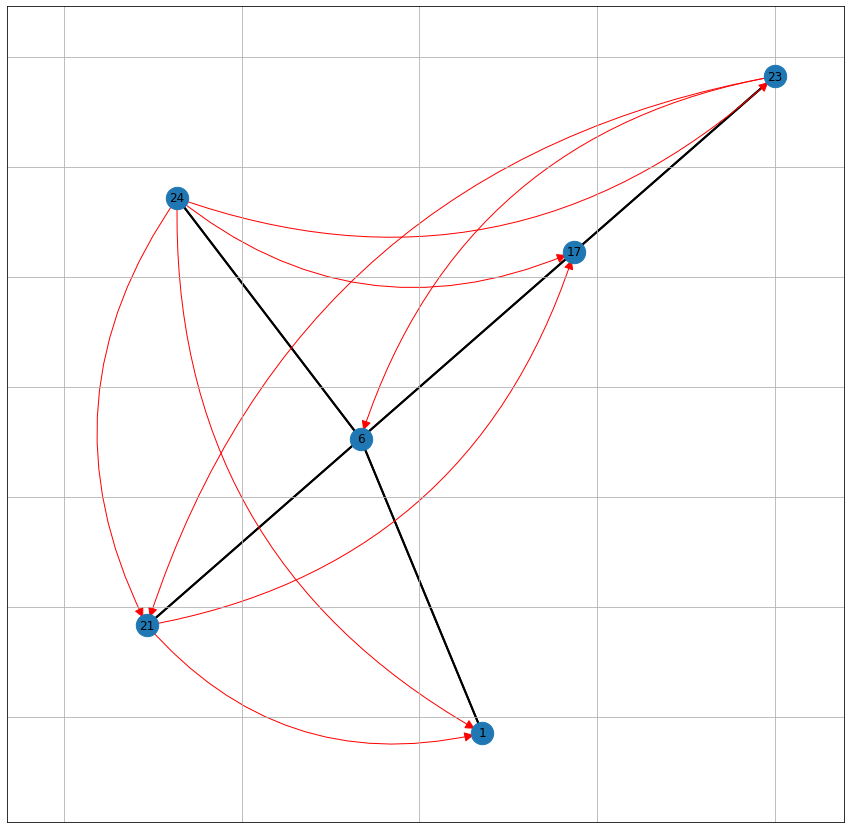

In [34]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:20,620 - HP2P - INFO - node 1 is removed - primray 6
2019-08-23 13:22:20,621 - HP2P - INFO - 6 got no entry node. It may be normal
2019-08-23 13:22:20,621 - HP2P - INFO - [leave] 6 recover_outgoing_candidate failed ... pass
2019-08-23 13:22:20,622 - HP2P - CRITICAL - 6 failed to be connected to this tree, so, WHAT???


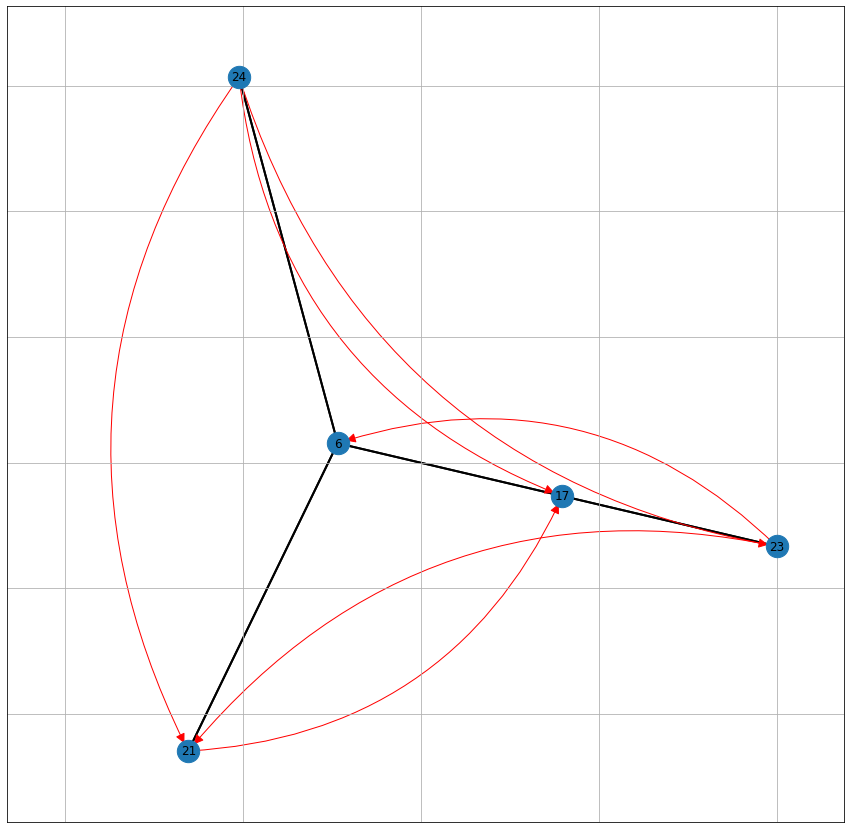

In [35]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:20,913 - HP2P - INFO - node 17 is removed - primray 6 23


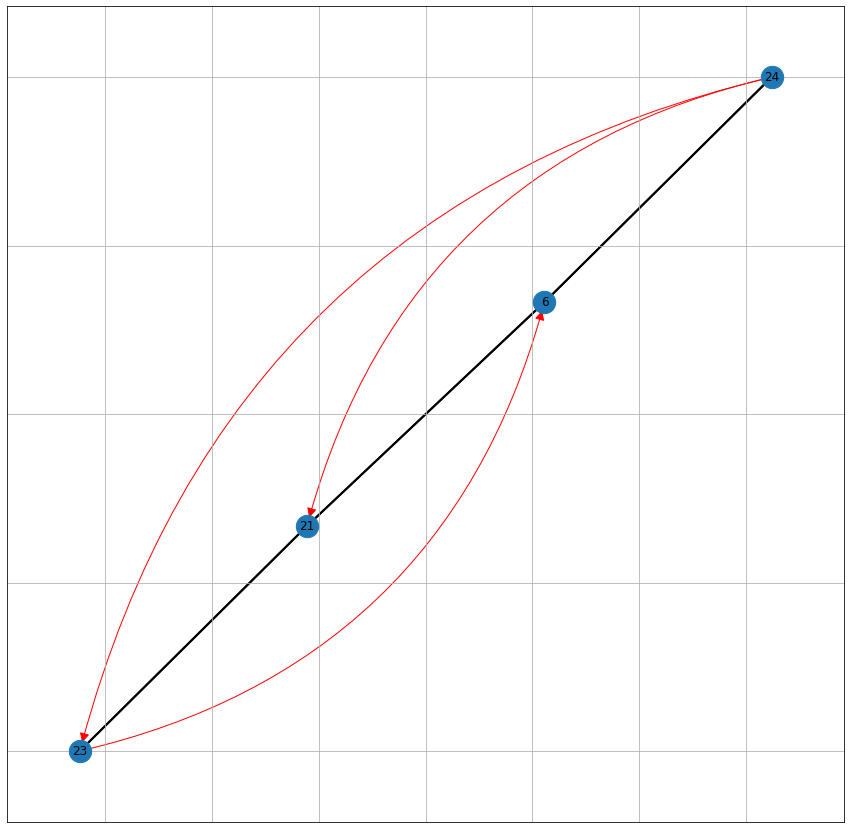

In [36]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:21,199 - HP2P - INFO - node 21 is removed - primray 6 23


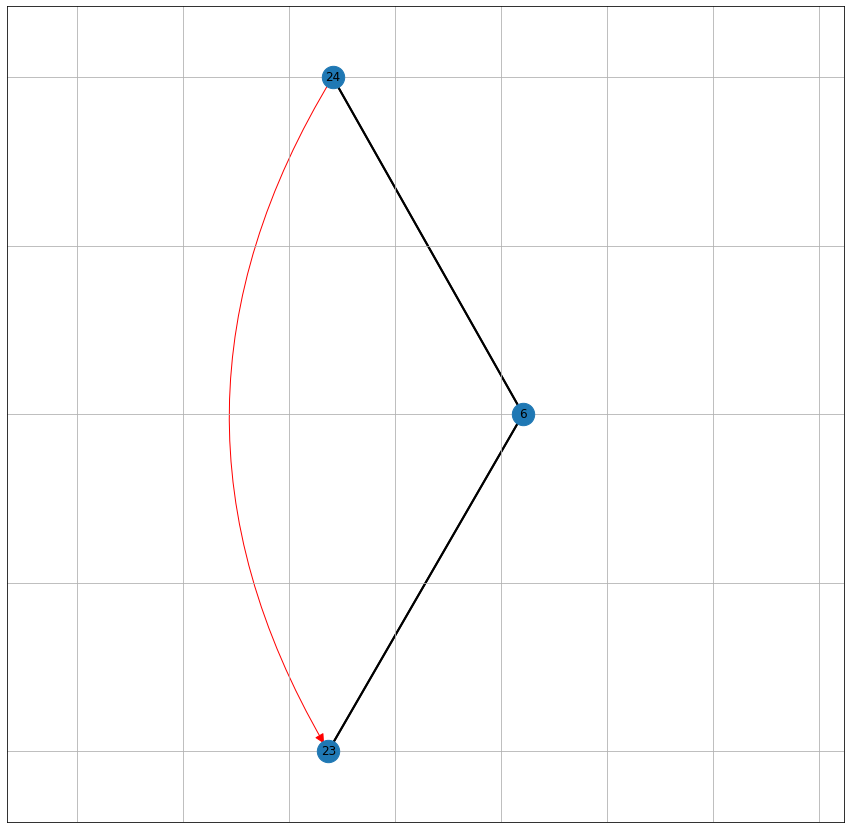

In [37]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:21,459 - HP2P - INFO - node 23 is removed - primray 6


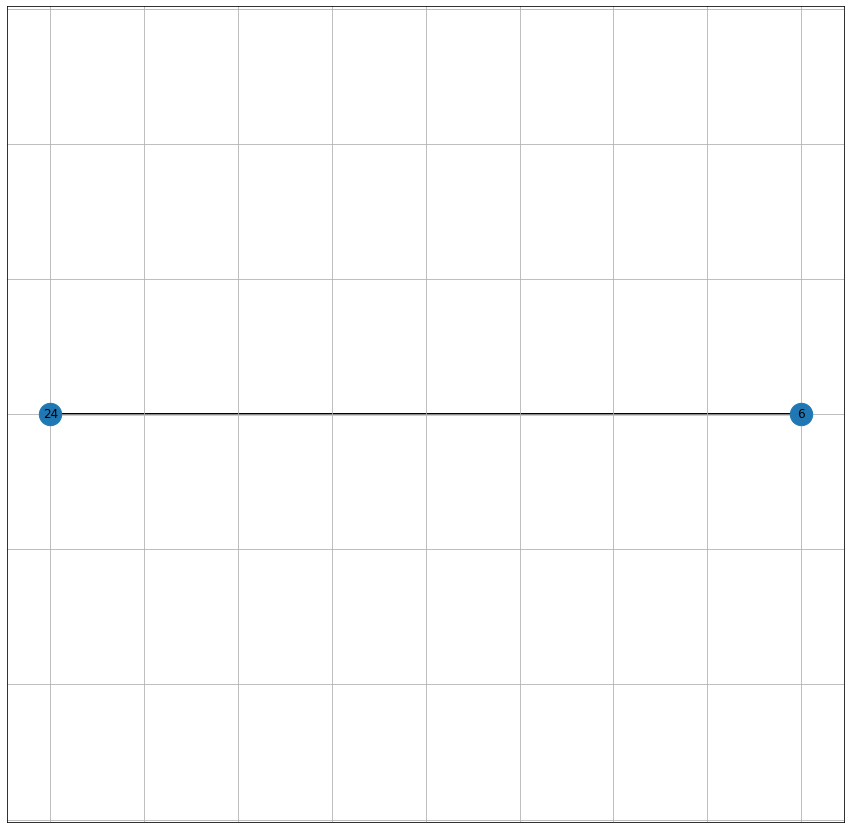

In [38]:
sim.del_random_node(1)
sim.draw_graph()

2019-08-23 13:22:21,719 - HP2P - INFO - node 6 is removed - primray 24
2019-08-23 13:22:21,720 - HP2P - INFO - 24 got no entry node. It may be normal
2019-08-23 13:22:21,720 - HP2P - INFO - [leave] 24 recover_outgoing_candidate failed ... pass
2019-08-23 13:22:21,720 - HP2P - CRITICAL - 24 failed to be connected to this tree, so, WHAT???


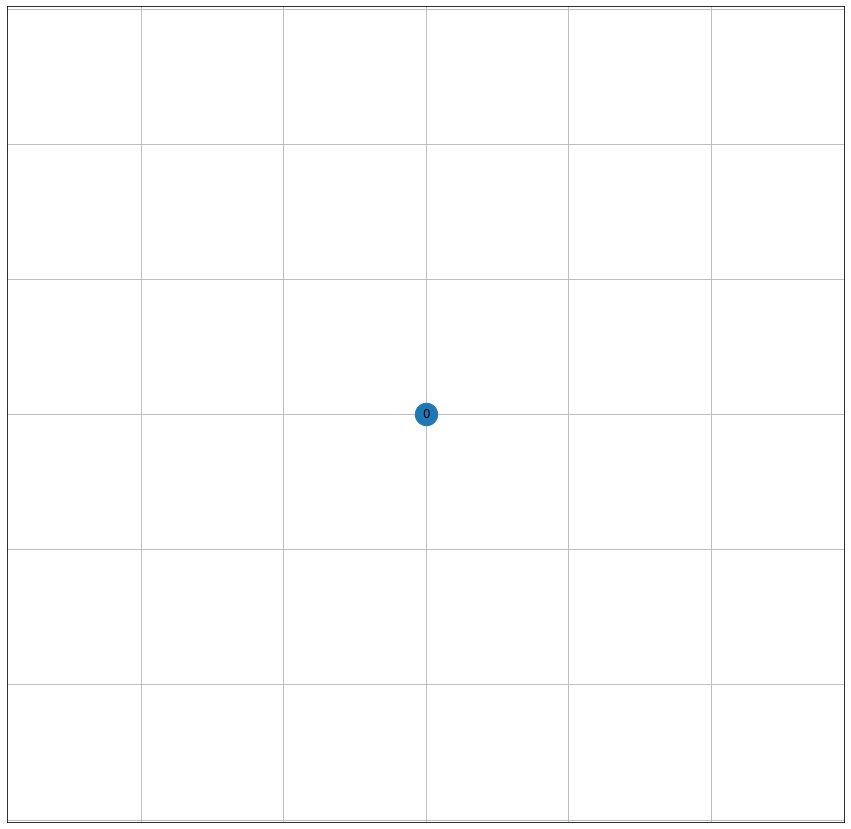

In [39]:
sim.del_random_node(1)
sim.draw_graph()

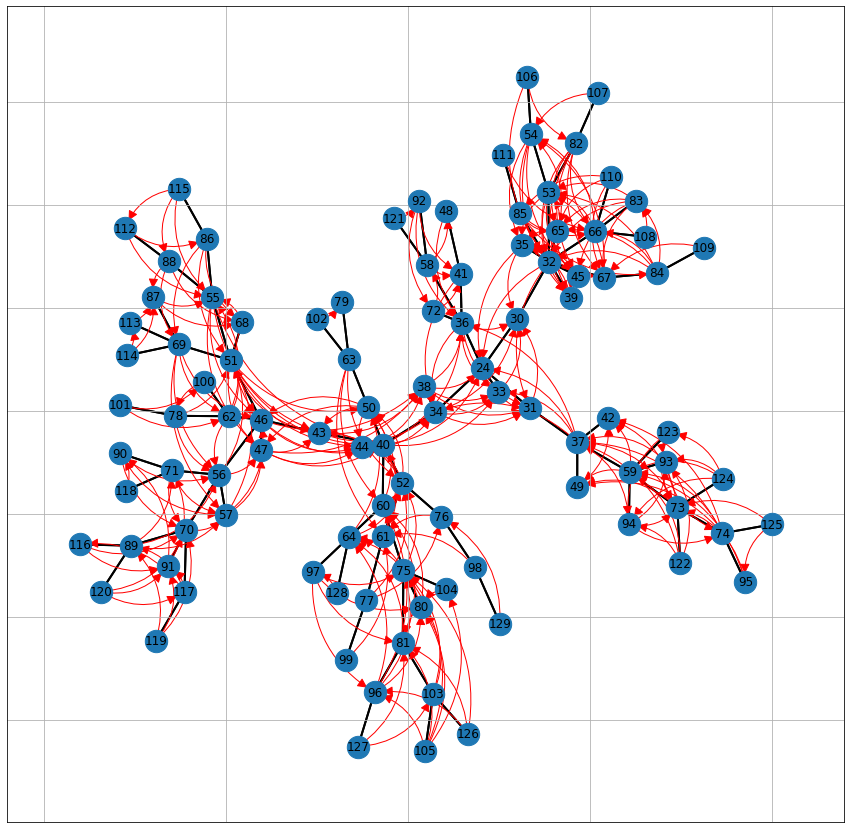

In [40]:
sim.add_random_node(100)
sim.draw_graph()

2019-08-23 13:22:23,565 - HP2P - INFO - node 110 is removed - primray 66
2019-08-23 13:22:23,566 - HP2P - INFO - node 55 is removed - primray 51 86 88
2019-08-23 13:22:23,566 - HP2P - INFO - node 43 is removed - primray 40 46
2019-08-23 13:22:23,567 - HP2P - INFO - node 31 is removed - primray 24 37
2019-08-23 13:22:23,567 - HP2P - INFO - node 60 is removed - primray 40 64 75
2019-08-23 13:22:23,568 - HP2P - INFO - node 95 is removed - primray 74
2019-08-23 13:22:23,568 - HP2P - INFO - node 97 is removed - primray 64
2019-08-23 13:22:23,569 - HP2P - INFO - node 87 is removed - primray 69 88
2019-08-23 13:22:23,570 - HP2P - INFO - node 44 is removed - primray 40
2019-08-23 13:22:23,570 - HP2P - INFO - node 35 is removed - primray 32
2019-08-23 13:22:23,571 - HP2P - INFO - node 57 is removed - primray 56
2019-08-23 13:22:23,571 - HP2P - INFO - node 77 is removed - primray 61 99
2019-08-23 13:22:23,572 - HP2P - INFO - node 63 is removed - primray 50 79 102
2019-08-23 13:22:23,573 - HP2P -

2019-08-23 13:22:23,625 - HP2P - INFO - node 116 is removed - primray 34 117
2019-08-23 13:22:23,626 - HP2P - INFO - [0 iteration] 117 send HELLO to 34
2019-08-23 13:22:23,627 - HP2P - INFO - node 107 is removed - primray 34
2019-08-23 13:22:23,627 - HP2P - INFO - node 96 is removed - primray 73
2019-08-23 13:22:23,628 - HP2P - INFO - node 61 is removed - primray 76 34 71
2019-08-23 13:22:23,628 - HP2P - INFO - [0 iteration] 76 send HELLO to 34
2019-08-23 13:22:23,629 - HP2P - INFO - node 117 is removed - primray 119 76
2019-08-23 13:22:23,629 - HP2P - INFO - [0 iteration] 119 send HELLO to 34
2019-08-23 13:22:23,630 - HP2P - INFO - node 119 is removed - primray 51
2019-08-23 13:22:23,630 - HP2P - INFO - node 102 is removed - primray 34
2019-08-23 13:22:23,630 - HP2P - INFO - node 76 is removed - primray 129 34
2019-08-23 13:22:23,631 - HP2P - INFO - [0 iteration] 129 send HELLO to 34
2019-08-23 13:22:23,633 - HP2P - INFO - node 34 is removed - primray 51 73 71
2019-08-23 13:22:23,633 

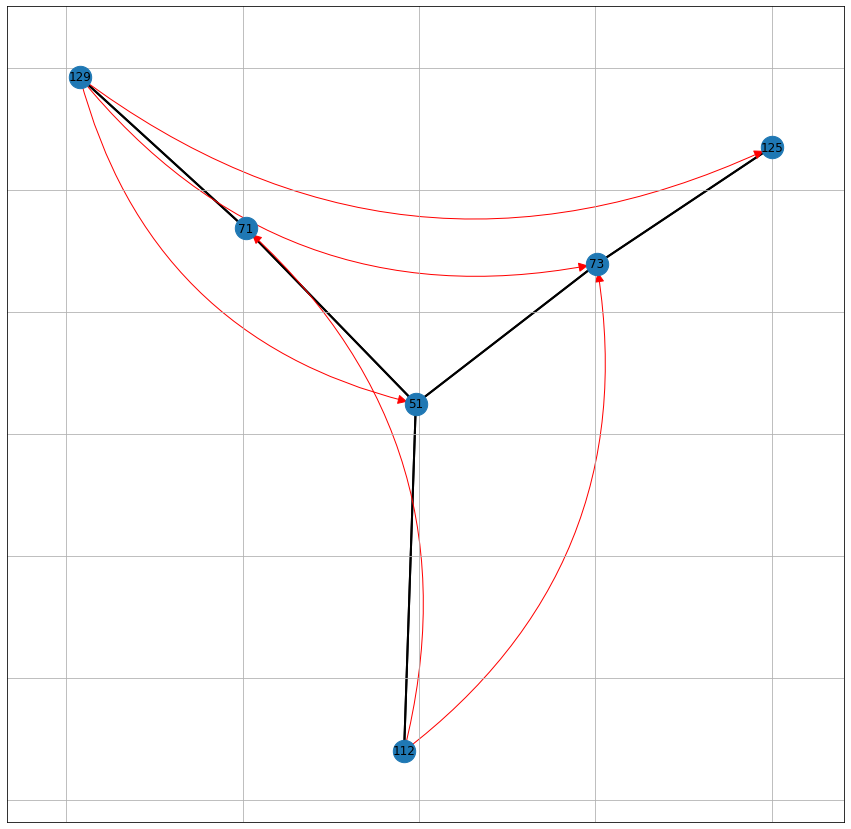

In [41]:
sim.del_random_node(95)
sim.draw_graph()

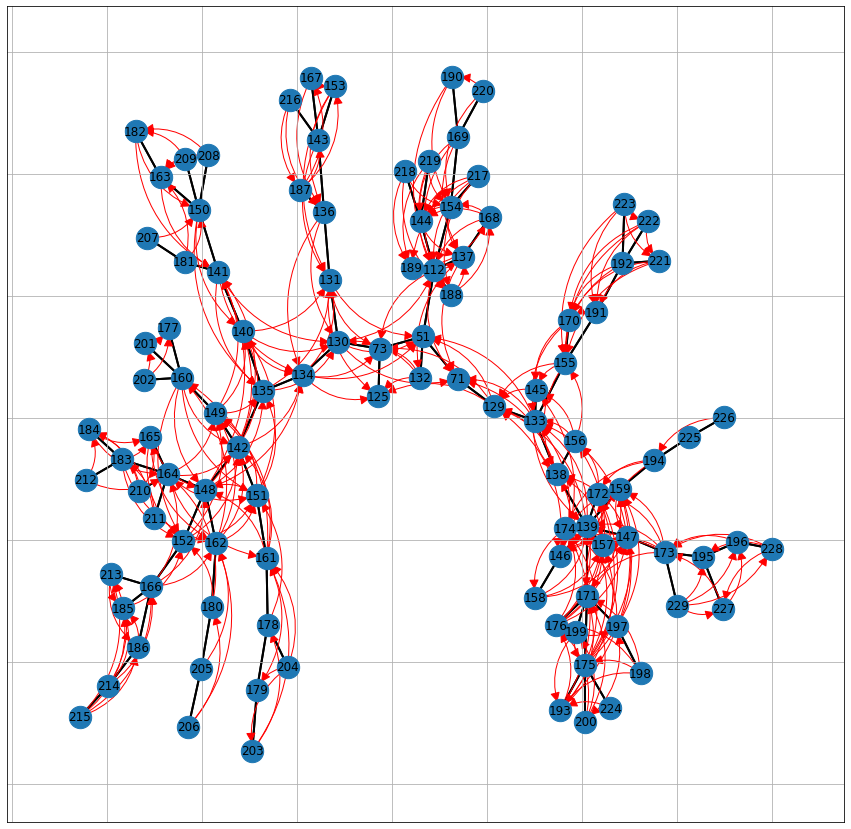

In [42]:
sim.add_random_node(100)
sim.draw_graph()

2019-08-23 13:22:25,703 - HP2P - INFO - node 202 is removed - primray 160
2019-08-23 13:22:25,704 - HP2P - INFO - node 129 is removed - primray 71 133
2019-08-23 13:22:25,705 - HP2P - INFO - node 160 is removed - primray 149 177 201
2019-08-23 13:22:25,705 - HP2P - INFO - [0 iteration] 177 send HELLO to 51
2019-08-23 13:22:25,706 - HP2P - INFO - node 226 is removed - primray 225
2019-08-23 13:22:25,706 - HP2P - INFO - node 153 is removed - primray 143
2019-08-23 13:22:25,706 - HP2P - INFO - node 185 is removed - primray 166
2019-08-23 13:22:25,707 - HP2P - INFO - node 173 is removed - primray 147 195 229
2019-08-23 13:22:25,707 - HP2P - INFO - [0 iteration] 195 send HELLO to 51
2019-08-23 13:22:25,708 - HP2P - INFO - node 159 is removed - primray 139 194
2019-08-23 13:22:25,708 - HP2P - INFO - node 162 is removed - primray 148 180
2019-08-23 13:22:25,709 - HP2P - INFO - node 140 is removed - primray 135 141
2019-08-23 13:22:25,709 - HP2P - INFO - node 192 is removed - primray 191 221 2

2019-08-23 13:22:25,769 - HP2P - INFO - node 190 is removed - primray 144
2019-08-23 13:22:25,770 - HP2P - INFO - node 179 is removed - primray 177
2019-08-23 13:22:25,771 - HP2P - INFO - node 136 is removed - primray 131 216 184
2019-08-23 13:22:25,771 - HP2P - INFO - [0 iteration] 216 send HELLO to 131
2019-08-23 13:22:25,772 - HP2P - INFO - node 141 is removed - primray 181 134 142 145 182
2019-08-23 13:22:25,773 - HP2P - INFO - [0 iteration] 181 send HELLO to 131
2019-08-23 13:22:25,773 - HP2P - INFO - [0 iteration] 182 send HELLO to 131
2019-08-23 13:22:25,774 - HP2P - INFO - node 221 is removed - primray 155 223
2019-08-23 13:22:25,774 - HP2P - INFO - node 224 is removed - primray 193
2019-08-23 13:22:25,775 - HP2P - INFO - node 195 is removed - primray 196 177
2019-08-23 13:22:25,775 - HP2P - INFO - [0 iteration] 196 send HELLO to 131
2019-08-23 13:22:25,776 - HP2P - INFO - node 223 is removed - primray 155
2019-08-23 13:22:25,776 - HP2P - INFO - node 214 is removed - primray 18

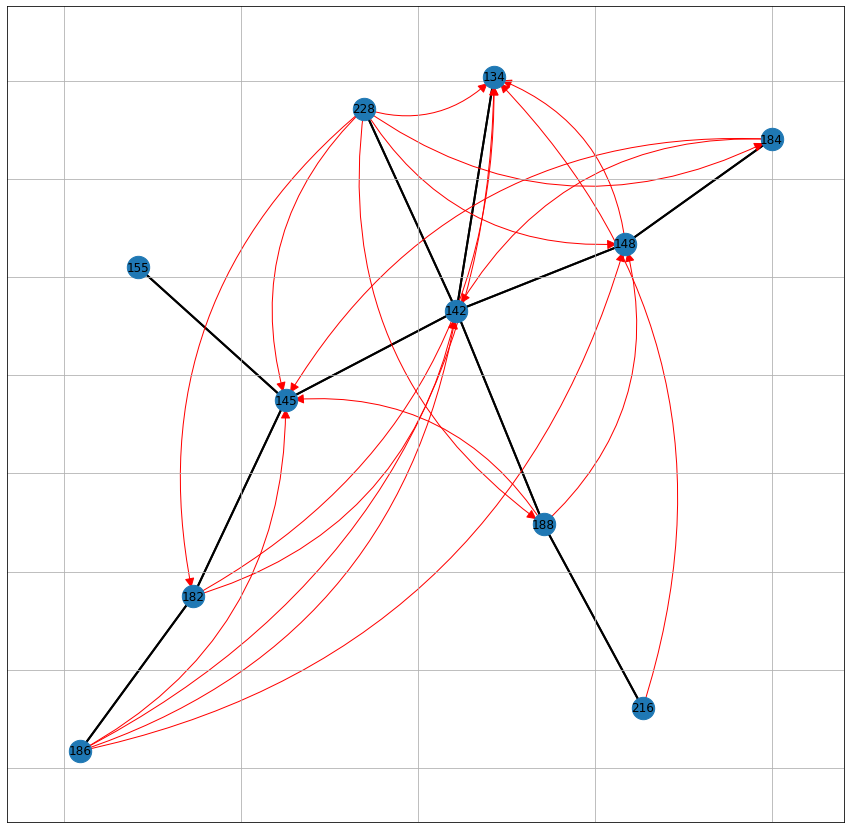

In [43]:
sim.del_random_node(95)
sim.draw_graph()

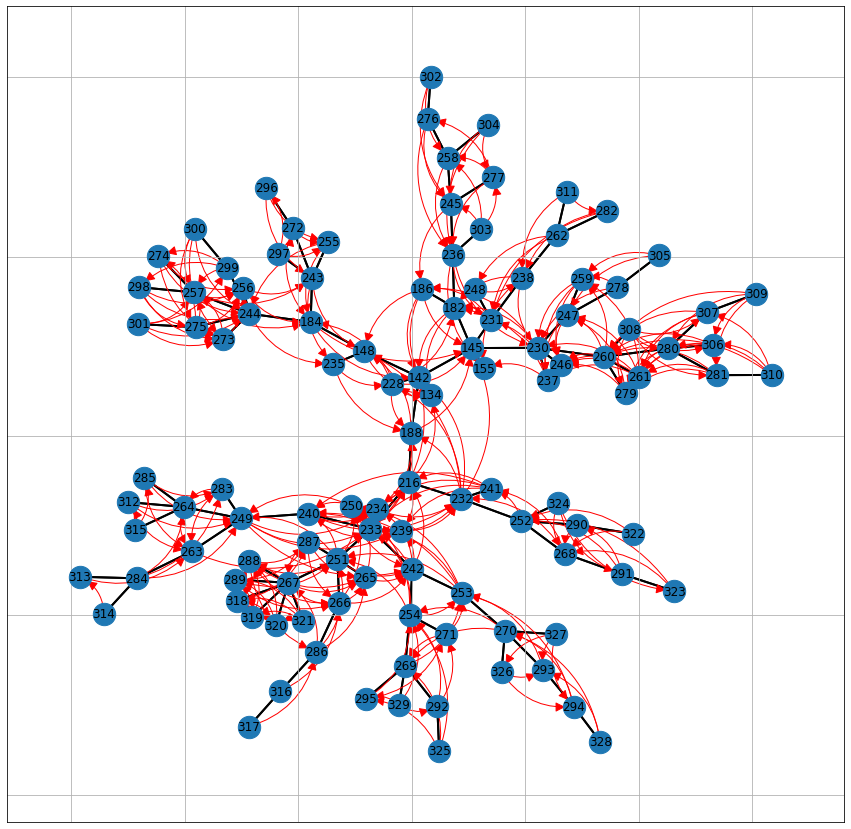

In [44]:
sim.add_random_node(100)
sim.draw_graph()

2019-08-23 13:22:27,910 - HP2P - INFO - node 297 is removed - primray 243
2019-08-23 13:22:27,910 - HP2P - INFO - node 319 is removed - primray 267
2019-08-23 13:22:27,911 - HP2P - INFO - node 316 is removed - primray 286 317
2019-08-23 13:22:27,912 - HP2P - INFO - node 274 is removed - primray 257
2019-08-23 13:22:27,912 - HP2P - INFO - node 184 is removed - primray 148 243 244
2019-08-23 13:22:27,913 - HP2P - INFO - node 253 is removed - primray 242 270
2019-08-23 13:22:27,914 - HP2P - INFO - node 307 is removed - primray 280 309
2019-08-23 13:22:27,914 - HP2P - INFO - node 237 is removed - primray 230
2019-08-23 13:22:27,914 - HP2P - INFO - node 310 is removed - primray 281
2019-08-23 13:22:27,915 - HP2P - INFO - node 300 is removed - primray 299
2019-08-23 13:22:27,915 - HP2P - INFO - node 287 is removed - primray 251
2019-08-23 13:22:27,916 - HP2P - INFO - node 232 is removed - primray 216 241 252
2019-08-23 13:22:27,917 - HP2P - INFO - node 155 is removed - primray 145
2019-08-23

2019-08-23 13:22:27,976 - HP2P - INFO - node 228 is removed - primray 258 233 246 285 145 244
2019-08-23 13:22:27,977 - HP2P - INFO - [0 iteration] 258 send HELLO to 145
2019-08-23 13:22:27,977 - HP2P - INFO - [0 iteration] 233 send HELLO to 145
2019-08-23 13:22:27,978 - HP2P - INFO - [0 iteration] 244 send HELLO to 145
2019-08-23 13:22:27,978 - HP2P - INFO - node 321 is removed - primray 258
2019-08-23 13:22:27,979 - HP2P - INFO - node 258 is removed - primray 276 145 285
2019-08-23 13:22:27,979 - HP2P - INFO - [0 iteration] 276 send HELLO to 145
2019-08-23 13:22:27,980 - HP2P - INFO - node 273 is removed - primray 244
2019-08-23 13:22:27,981 - HP2P - INFO - node 256 is removed - primray 244
2019-08-23 13:22:27,981 - HP2P - INFO - node 292 is removed - primray 325 271 329
2019-08-23 13:22:27,982 - HP2P - INFO - [0 iteration] 325 send HELLO to 145
2019-08-23 13:22:27,982 - HP2P - INFO - [0 iteration] 329 send HELLO to 145
2019-08-23 13:22:27,983 - HP2P - INFO - node 281 is removed - pr

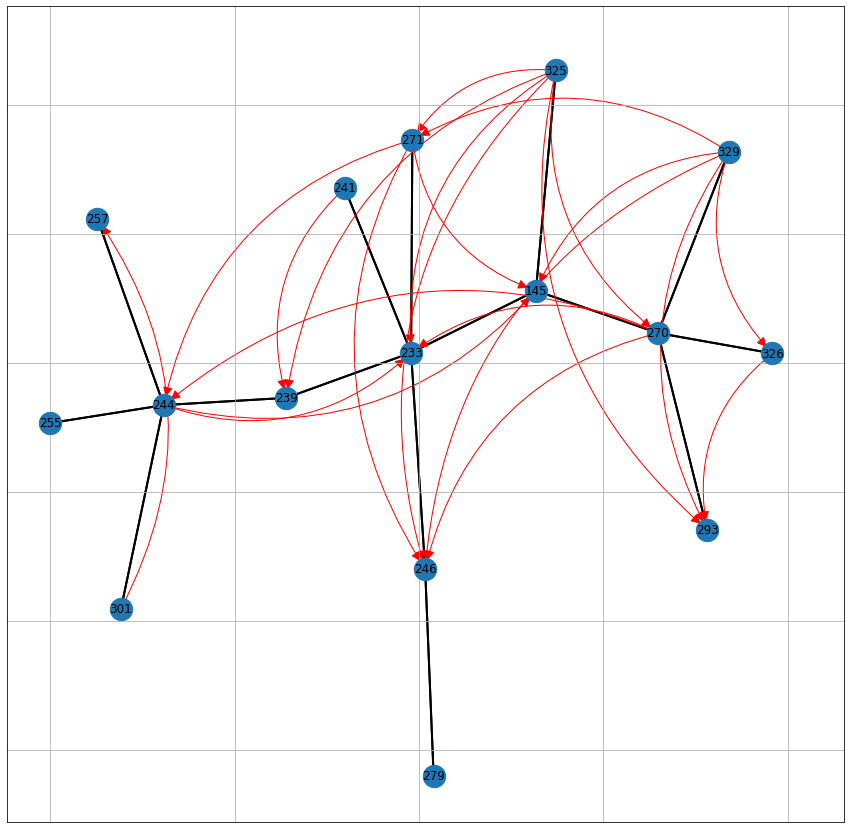

In [45]:
sim.del_random_node(95)
sim.draw_graph()

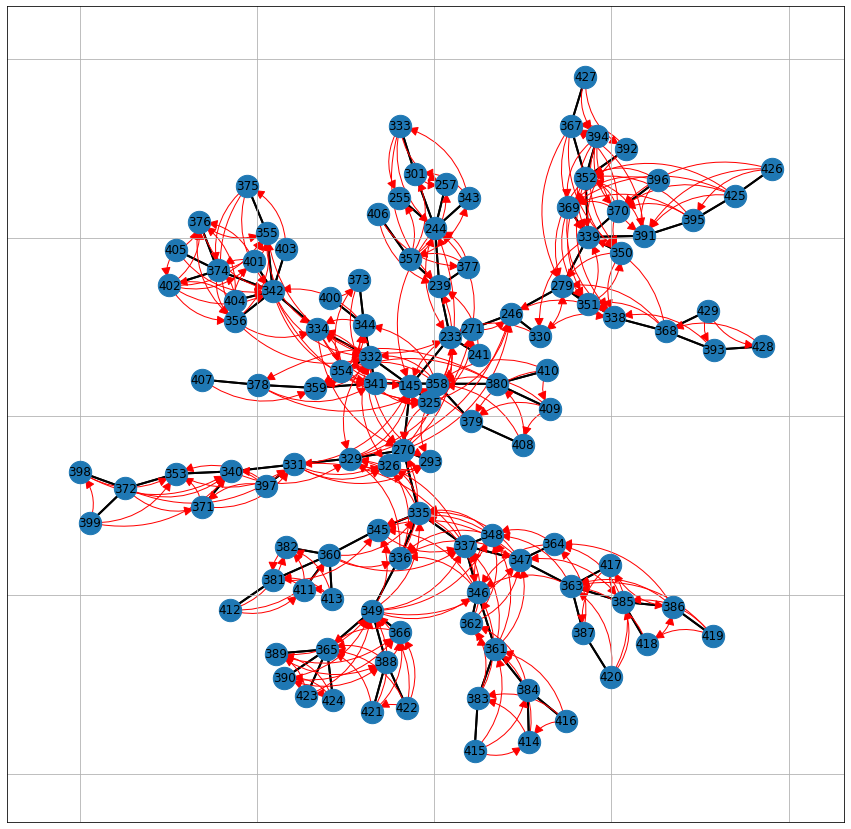

In [46]:
sim.add_random_node(100)
sim.draw_graph()

2019-08-23 13:22:30,187 - HP2P - INFO - node 361 is removed - primray 346 383 384
2019-08-23 13:22:30,188 - HP2P - INFO - node 377 is removed - primray 239
2019-08-23 13:22:30,188 - HP2P - INFO - node 386 is removed - primray 385 419
2019-08-23 13:22:30,189 - HP2P - INFO - node 385 is removed - primray 363 418
2019-08-23 13:22:30,189 - HP2P - INFO - node 400 is removed - primray 344
2019-08-23 13:22:30,190 - HP2P - INFO - node 387 is removed - primray 363 420
2019-08-23 13:22:30,190 - HP2P - INFO - node 419 is removed - primray 418
2019-08-23 13:22:30,191 - HP2P - INFO - node 408 is removed - primray 379
2019-08-23 13:22:30,191 - HP2P - INFO - node 145 is removed - primray 270 233 325 332
2019-08-23 13:22:30,192 - HP2P - INFO - 233 got no entry node. It may be normal
2019-08-23 13:22:30,193 - HP2P - INFO - [leave] 233 recover_outgoing_candidate failed ... pass
2019-08-23 13:22:30,193 - HP2P - CRITICAL - 233 failed to be connected to this tree, so, WHAT???
2019-08-23 13:22:30,194 - HP2P

2019-08-23 13:22:30,253 - HP2P - INFO - node 341 is removed - primray 241 427
2019-08-23 13:22:30,253 - HP2P - INFO - node 416 is removed - primray 384
2019-08-23 13:22:30,254 - HP2P - INFO - node 239 is removed - primray 233
2019-08-23 13:22:30,254 - HP2P - INFO - node 383 is removed - primray 415 384 233
2019-08-23 13:22:30,255 - HP2P - INFO - node 413 is removed - primray 381
2019-08-23 13:22:30,256 - HP2P - INFO - node 380 is removed - primray 409 343
2019-08-23 13:22:30,257 - HP2P - INFO - [0 iteration] 409 send HELLO to 233
2019-08-23 13:22:30,257 - HP2P - INFO - node 409 is removed - primray 329
2019-08-23 13:22:30,258 - HP2P - INFO - node 425 is removed - primray 395
2019-08-23 13:22:30,259 - HP2P - INFO - node 381 is removed - primray 382 241 427
2019-08-23 13:22:30,260 - HP2P - INFO - [0 iteration] 382 send HELLO to 233
2019-08-23 13:22:30,260 - HP2P - INFO - node 241 is removed - primray 233 417 404 384
2019-08-23 13:22:30,261 - HP2P - INFO - [0 iteration] 384 send HELLO to 

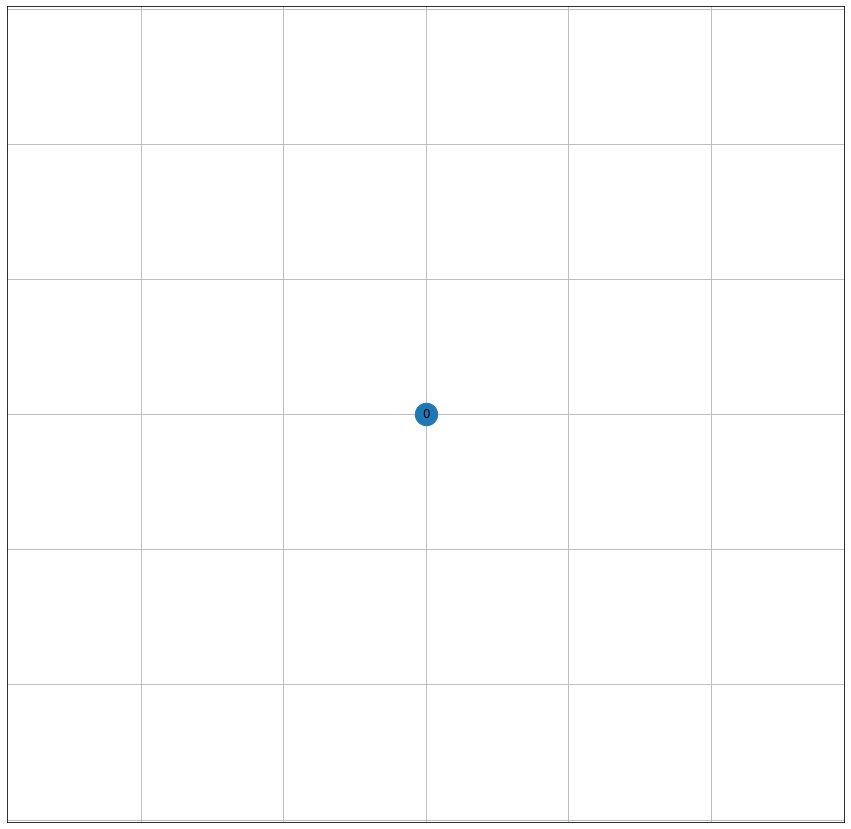

In [47]:
sim.del_random_node(115)
sim.draw_graph()

In [48]:
sound_alert()